# A3: Make Your Own Machine Translation 

In this assignment, we will explore the domain of neural machine translation. The focus will be on
translating between your native language and English. We will experiment with different types of attention
mechanisms, including general attention, multiplicative attention, and additive attention, to evaluate their
effectiveness in the translation process.

#### Step 0: Prepare Environment - Import Libraries and select device

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import datasets, math, re, random, time
from collections import Counter
from tqdm import tqdm

In [2]:
# mimimum required torch version for MPS support "1.12+"
torch.__version__

'2.10.0'

In [3]:
# universal device selection: use gpu if available, else cpu
import torch

def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")      # NVIDIA GPU
    elif torch.backends.mps.is_available():
        return torch.device("mps")       # Apple Silicon GPU
    else:
        return torch.device("cpu")

device = get_device()

print(f"Using device: {device}")

# CPU preferred, as MPS keeps on crashing during training with memory errors.
#RuntimeError: MPS backend out of memory (MPS allocated: 86.95 GiB, 
# other allocations: 1.14 GiB, max allowed: 88.13 GiB). Tried to allocate 42.25 MiB on private pool. 
# Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Using device: mps


## Task 1. Get Language Pair - Based on MT + Transformer.ipynb, modify the dataset as follows:

### 1.1) Find a dataset suitable for translation between your native language and English. Ensure to source this dataset from reputable public databases or repositories. It is imperative to give proper credit to the dataset source in your documentation. (1 points)


Context Behind Nepali Language:

My native language is Nepali. It is spoken by roughly 32 million people around the world as first or second language. 
Percentage estimate is ~0.4% (total estimated world population 8 Billion people).

There's few coproa exists on Nepali to English translation on Hugging Face.
1. Opus project [Helsinki NLP Research](https://huggingface.co/datasets/Helsinki-NLP/opus-100/viewer/en-ne)

Helsinki-NLP refers to the language technology research group at the University of Helsinki. Here, we publish various resource related to multilingual NLP, machine translation, text simplification to name a few application areas. We focus on wide language coverage, open data sets and public pre-trained models.

2. [IRIIS project](https://huggingface.co/IRIIS-RESEARCH)
IRIIS-Research is a research group that publishes large-scale raw text corpora on Hugging Face, including one of the largest publicly available Nepali text datasets. This is monolingual Nepali text and large dataset in GBs (~10 GB). 

3. [ERLA](https://catalog.elra.info/en-us/repository/search/?q=nepali)

Founded in 1995, ELRA, the ELRA Language Resources Association is a non-profit organisation whose main mission is to make Language Resources (LRs) for Human Language Technologies (HLT) available to the community at large.

4. [FLORES+](https://huggingface.co/datasets/openlanguagedata/flores_plus)
FLORES+ is a multilingual machine translation benchmark released under CC BY-SA 4.0. This dataset was originally released by FAIR researchers at Meta under the name FLORES. Further information about these initial releases can be found in Dataset Sources below. The data is now being managed by OLDI, the Open Language Data Initiative. The + has been added to the name to disambiguate between the original datasets and this new actively developed version.

Archived Flores : [Flores 200](https://huggingface.co/datasets/facebook/flores/blob/main/README.md#dataset-card-for-flores-200)

More on research paper [Natural language processing for Nepali text: a review](../resources/Shahi-Sitaula2021_Article_NaturalLanguageProcessingForNe.pdf)

<strong>For the assignment purpose, I am using smaller dataset from hugging face OPUS-100</strong>

Opus chosen for:
1. Better quality
2. Proper train/val/test split
3. Managable size with subset
4. More realistic results

** Tatoeba dataset is smaller good for fast training but it has simple sentences, and may not generalize well.


| Dataset     | Size                | Languages      | Use Case                | Quality                  |
|-------------|---------------------|----------------|-------------------------|--------------------------|
| WMT14       | ~4.5M pairs (de-en) | 2-6 pairs      | Training                | High (news)              |
| WMT16       | ~4.5M pairs         | 6-8 pairs      | Training                | High (news)              |
| WMT19       | ~38M pairs (de-en)  | 10+ pairs      | Training                | High (news)              |
| OPUS-100    | ~55M total          | 100 languages  | Multilingual training   | Medium                   |
| Tatoeba     | ~10M total          | 400+ languages | Evaluation/Small training| Medium (user-contributed)|


#### Step 1: Data preparation - using OPUS dataset

In [4]:
from datasets import load_dataset

_EN_LANGUAGE = 'en'
_NE_LANGUAGE = 'ne'
# Use "de-en" as dataset doesn't have en-de and treat English as source, German as target.
_LANG_PAIR = f"{_EN_LANGUAGE}-{_NE_LANGUAGE}"
print("Translation Language Pair:", _LANG_PAIR)

dataset = load_dataset("opus100", _LANG_PAIR)

Translation Language Pair: en-ne


In [5]:
dataset

DatasetDict({
    test: Dataset({
        features: ['translation'],
        num_rows: 2000
    })
    train: Dataset({
        features: ['translation'],
        num_rows: 406381
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 2000
    })
})

In [6]:
dataset['train'][100]

{'translation': {'en': 'The following item is due:',
  'ne': 'निम्न वस्तुको म्याद समाप्त हुन्छ:'}}

In [7]:
_TRAIN_SAMPLE_SIZE = 20_000  #100_000
# Selecting smaller subsets for faster training/testing
train = dataset["train"].select(range(_TRAIN_SAMPLE_SIZE))  # 100K samples
val = dataset["validation"]
test = dataset["test"]

print(f"Train: {len(train)}, Val: {len(val)}, Test: {len(test)}")

Train: 20000, Val: 2000, Test: 2000


In [8]:
train[0], val[0], test[0]

({'translation': {'en': '_Inv', 'ne': 'Inv'}},
 {'translation': {'en': '%1: the message is displayed silently.',
   'ne': '% 1: सन्देश ध्वनि बिना प्रदर्शित हुन्छ ।'}},
 {'translation': {'en': 'Delete Thread', 'ne': 'थ्रेड मेट्नुहोस्'}})


### 1.2) Describe in detail the process of preparing the dataset for use in your translation model. This includes steps like text normalization, tokenization, and word segmentation, particularly focusing on your native language’s specific requirements. Specify the libraries or tools you will use for these tasks and give appropriate credit to the developers or organizations behind these tools. If your native language requires special handling in tokenization (e.g., for languages like Chinese, Thai, or Japanese), mention the libraries (like Jieba, PyThaiNLP, or Mecab) and the procedures used for word segmentation. (1 points)

Note: proper attribution for both the dataset and the tools used in its processing is essential for maintaining
academic integrity.

#### Step 2: Data preprocessing


For English tokenization , pretarined model is used:

```bash
uv add spacy
uv add pip

uv run python3 -m spacy download en_core_web_sm 
```

Instead of downloading using uv python, using python script download and save to local.

There's no spaCy model for Nepali. For tokenization, 

1. use tokenizing algorithm and train on data 
    
    Pros: Customized according to data, handles OOV
    
    Cons: Need to train


SentencePiece is a tokenization algorithm (BPE or unigram) - it's simpler and faster.

2. Use pretrained tokenizer
    
    Pros: Ready to use

    Cons: May not fit to dataset used


```python
from transformers import AutoTokenizer

# Already trained, supports Nepali!
tokenizer = AutoTokenizer.from_pretrained("facebook/nllb-200-distilled-600M")
```

Using pre-trained model from Meta [NLLB](https://github.com/facebookresearch/fairseq/tree/nllb)

Research Paper : [No Language Left Behind:Scaling Human-Centered Machine Translation](https://arxiv.org/abs/2207.04672)



Create two dictionaries 1. for holding our tokenizers and 2. for holding all the vocabs with assigned numbers for each unique word

In [9]:
# Place-holders
token_transform = {}
vocab_transform = {}

In [10]:
import spacy
from spacy.cli import download
import os
import shutil
import glob

from transformers import AutoTokenizer

_MODEL_DIRECTORY = "./../models"

# Create models directory
os.makedirs(_MODEL_DIRECTORY, exist_ok=True)

_SPACY_MODEL_PATH = os.path.join(_MODEL_DIRECTORY, "en_core_web_sm")

def load_spacy_model():
    """Load spaCy model from custom directory, download if needed"""
    # Check if config.cfg exists (proper model structure)
    if os.path.exists(os.path.join(_SPACY_MODEL_PATH, "config.cfg")):
        return spacy.load(_SPACY_MODEL_PATH)
    
    # Download and copy to custom folder
    print("Downloading spaCy model...")
    download("en_core_web_sm")
    
    import en_core_web_sm
    source_path = en_core_web_sm.__path__[0]
    
    # Find the actual model directory (contains config.cfg)
    # It's usually nested like: en_core_web_sm/en_core_web_sm-3.x.x/
    # Config checks added to fix - OSError: [E053] Could not read config file from ../models/en_core_web_sm/config.cfg
    config_files = glob.glob(os.path.join(source_path, "**", "config.cfg"), recursive=True)
    if config_files:
        actual_model_dir = os.path.dirname(config_files[0])
    else:
        actual_model_dir = source_path
    
    # Copy the actual model files
    os.makedirs(_MODEL_DIRECTORY, exist_ok=True)
    if os.path.exists(_SPACY_MODEL_PATH):
        shutil.rmtree(_SPACY_MODEL_PATH)
    shutil.copytree(actual_model_dir, _SPACY_MODEL_PATH)
    
    # Load spaCy models directly (faster than get_tokenizer for batch processing)
    return spacy.load(_SPACY_MODEL_PATH, disable=["parser", "tagger", "ner", "lemmatizer"])


def load_nllb():
    """Load NLLB tokenizer from custom directory, download if needed"""
    nllb_path = os.path.join(_MODEL_DIRECTORY, "nllb-tokenizer")
    if os.path.exists(nllb_path):
        return AutoTokenizer.from_pretrained(nllb_path)
    
    print("Downloading NLLB tokenizer...")
    tokenizer = AutoTokenizer.from_pretrained("facebook/nllb-200-distilled-600M")
    tokenizer.save_pretrained(nllb_path)
    return tokenizer

In [11]:
spacy_model = load_spacy_model()

# Add English tokenizer to token_transform
def spacy_tokenize(text):
    """Tokenize text using spaCy"""
    return [tok.text for tok in spacy_model(text)]

token_transform[_EN_LANGUAGE] = spacy_tokenize

In [12]:
from transformers import AutoTokenizer

nllb = load_nllb()
sample_nepali_sentence = "नेपाल सुन्दर छ"

# Add Nepali tokenizer to token_transform
token_transform[_NE_LANGUAGE] = nllb.tokenize

print(token_transform[_NE_LANGUAGE](sample_nepali_sentence))

['▁नेपाल', '▁सुन्दर', '▁छ']


In [13]:
train_nepali_text = train[100]['translation'][_NE_LANGUAGE]
print("Sentence:", train_nepali_text)
print("Tokenization: ", token_transform[_NE_LANGUAGE](train_nepali_text))

Sentence: निम्न वस्तुको म्याद समाप्त हुन्छ:
Tokenization:  ['▁निम्न', '▁वस्तु', 'को', '▁म्या', 'द', '▁समाप्त', '▁हुन्छ', ':']


In [14]:
#example of tokenization of the english part
train_english_text = train[100]['translation'][_EN_LANGUAGE]
print("Sentence:", train_english_text)
print("Tokenization: ", token_transform[_EN_LANGUAGE](train_english_text))

Sentence: The following item is due:
Tokenization:  ['The', 'following', 'item', 'is', 'due', ':']


In [15]:
_SRC_LANGUAGE = _EN_LANGUAGE
_TRG_LANGUAGE = _NE_LANGUAGE

Function to token input

In [16]:
# helper function to yield list of tokens
# here data can be `train` or `val` or `test`
def yield_tokens(data, language):
    for data_sample in data:
        yield token_transform[language](data_sample['translation'][language])

Before we tokenize, let's define some special symbols so our neural network understand the embeddings of these symbols, namely the unknown, the padding, the start of sentence, and end of sentence.

special symbols `<unk>`, `<pad>`, `<sos>`, `<eos>` with indexes 0, 1, 2, 3 respectively. Where each symbol has meanings as such:
>
>   `<unk>`: To represent Unknown
>
>   `<pad>`: Padding, used to ensure all sequences are of same length
>
>   `<sos>`: Start of sentence
>
>   `<eos>`: End of sentence


#### Step 4: Numericalization

Next we gonna create function (torchtext called vocabs) that turn these tokens into integers.  Here we build Vocab class as torchtext.vocab is not supported in Python v3.13+

In [17]:
# torchtext.vocab replacement - Vocab class to mimic torchtext API
from collections import Counter

# Define special symbols and indices
_UNK_IDX, _PAD_IDX, _SOS_IDX, _EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
_SPECIAL_SYMBOLS = ['<unk>', '<pad>', '<sos>', '<eos>']

class Vocab:
    """A simple Vocab class to replace torchtext.vocab"""
    def __init__(self, stoi, itos, default_index=0):
        self.stoi = stoi  # string to index
        self.itos = itos  # index to string (list)
        self.default_index = default_index
    
    def __call__(self, tokens):
        """Convert list of tokens to list of indices"""
        return [self.stoi.get(token, self.default_index) for token in tokens]
    
    def __len__(self):
        return len(self.itos)
    
    def __getitem__(self, token):
        return self.stoi.get(token, self.default_index)
    
    def set_default_index(self, index):
        self.default_index = index
    
    def get_itos(self):
        return self.itos

def build_vocab(token_iterator, min_freq=2, specials=None, special_first=True):
    """Build vocabulary from token iterator"""
    if specials is None:
        specials = []
    
    # Count token frequencies
    counter = Counter()
    for tokens in token_iterator:
        counter.update(tokens)
    
    # Build itos (index to string) list
    itos = []
    if special_first:
        itos.extend(specials)
    
    # Add tokens that meet min_freq threshold
    for token, freq in counter.items():
        if freq >= min_freq and token not in specials:
            itos.append(token)
    
    if not special_first:
        itos.extend(specials)
    
    # Build stoi (string to index) dict
    stoi = {token: idx for idx, token in enumerate(itos)}
    
    return Vocab(stoi, itos)

In [18]:
from concurrent.futures import ThreadPoolExecutor
import time
from tqdm import tqdm

def build_vocab_en_fast(data):
    """Build English vocab using spaCy's fast pipe() method"""
    print(f"Building vocab for {_EN_LANGUAGE} (batch mode)...")
    start = time.time()
    
    # Collect all English texts
    texts = [sample['translation'][_EN_LANGUAGE] for sample in tqdm(data, desc="Collecting EN texts")]
    
    # Batch tokenize with spaCy pipe() - MUCH faster!
    counter = Counter()
    for doc in tqdm(spacy_model.pipe(texts, batch_size=1000, n_process=1), 
                    total=len(texts), desc="Tokenizing EN"):
        counter.update([tok.text for tok in doc])
    
    # Build vocab
    itos = list(_SPECIAL_SYMBOLS)
    for token, freq in counter.items():
        if freq >= 2 and token not in _SPECIAL_SYMBOLS:
            itos.append(token)
    stoi = {token: idx for idx, token in enumerate(itos)}
    
    vocab = Vocab(stoi, itos)
    vocab.set_default_index(_UNK_IDX)
    print(f"  {_EN_LANGUAGE} done in {time.time() - start:.1f}s, vocab size: {len(vocab)}")
    return vocab

def build_vocab_ne(data):
    """Build Nepali vocab (NLLB tokenizer)"""
    print(f"Building vocab for {_NE_LANGUAGE}...")
    start = time.time()
    
    counter = Counter()
    for sample in tqdm(data, desc="Tokenizing NE"):
        tokens = token_transform[_NE_LANGUAGE](sample['translation'][_NE_LANGUAGE])
        counter.update(tokens)
    
    # Build vocab
    itos = list(_SPECIAL_SYMBOLS)
    for token, freq in counter.items():
        if freq >= 2 and token not in _SPECIAL_SYMBOLS:
            itos.append(token)
    stoi = {token: idx for idx, token in enumerate(itos)}
    
    vocab = Vocab(stoi, itos)
    vocab.set_default_index(_UNK_IDX)
    print(f"  {_NE_LANGUAGE} done in {time.time() - start:.1f}s, vocab size: {len(vocab)}")
    return vocab

# Build vocabularies in parallel
start_total = time.time()
with ThreadPoolExecutor(max_workers=2) as executor:
    future_en = executor.submit(build_vocab_en_fast, train)
    future_ne = executor.submit(build_vocab_ne, train)
    
    vocab_transform[_EN_LANGUAGE] = future_en.result()
    vocab_transform[_NE_LANGUAGE] = future_ne.result()

print(f"\nTotal time: {time.time() - start_total:.1f}s")
print(f"{_SRC_LANGUAGE} vocab size: {len(vocab_transform[_SRC_LANGUAGE])}")
print(f"{_TRG_LANGUAGE} vocab size: {len(vocab_transform[_TRG_LANGUAGE])}")

# Warning : Token indices sequence length is longer than the specified maximum sequence length for this model (3645 > 1024). Running this sequence through the model will result in indexing errors
print("""NLLB tokenizer warning about max sequence length may be ignored for vocab building. 
It is only used as a tokenizer here. The 1024 limit applies during model training/inference.""")

Building vocab for en (batch mode)...Building vocab for ne...



Tokenizing NE: 100%|██████████| 20000/20000 [00:00<00:00, 30509.71it/s]


  ne done in 0.7s, vocab size: 4785


Tokenizing EN: 100%|██████████| 20000/20000 [00:12<00:00, 1653.42it/s]

  en done in 12.2s, vocab size: 6151

Total time: 12.2s
en vocab size: 6151
ne vocab size: 4785
NLLB tokenizer warning about max sequence length may be ignored for vocab building. 
It is only used as a tokenizer here. The 1024 limit applies during model training/inference.


The parallalization addition didn't benefit much as the volume of Nepali dataset was not huge and NLLB is fast since it's implemented in Rust and it only took few seconds to get competed. 

The main time consuming tokenization was for EN language. After using `pipe()` for batch processing , the number reduced by more than 50%. It takes little more than 1 minute compared to ~3 minutes without batching.

In [19]:
vocab_transform[_SRC_LANGUAGE](['here', 'is', 'a', 'unknownword', 'a'])

[2412, 271, 201, 0, 201]

In [20]:
#we can reverse it....
mapping = vocab_transform[_SRC_LANGUAGE].get_itos()

#print 2822, for example
mapping[2822]

'lower'

In [21]:
mapping[0]


'<unk>'

In [22]:
#let's try special symbols
mapping[1], mapping[2], mapping[3]

('<pad>', '<sos>', '<eos>')

In [23]:
#check unique vocabularies
len(mapping)

6151

#### Step 5: Prepare data loaders

One thing we change here is the <code>collate_fn</code> which now also returns the length of sentence.  This is required for <code>packed_padded_sequence</code>

In [24]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids):
    return torch.cat((torch.tensor([_SOS_IDX]), 
                      torch.tensor(token_ids), 
                      torch.tensor([_EOS_IDX])))

# src and trg language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [_SRC_LANGUAGE, _TRG_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tensors
def collate_batch(batch):
    src_batch, src_len_batch, trg_batch = [], [], []
    for sample in batch:
        # OPUS-100 format: {'translation': {'en': '...', 'ne': '...'}}
        src_sample = sample['translation'][_SRC_LANGUAGE]
        trg_sample = sample['translation'][_TRG_LANGUAGE]
        
        processed_text = text_transform[_SRC_LANGUAGE](src_sample.rstrip("\n"))
        src_batch.append(processed_text)
        trg_batch.append(text_transform[_TRG_LANGUAGE](trg_sample.rstrip("\n")))
        src_len_batch.append(processed_text.size(0))

    src_batch = pad_sequence(src_batch, padding_value=_PAD_IDX)
    trg_batch = pad_sequence(trg_batch, padding_value=_PAD_IDX)
    return src_batch, torch.tensor(src_len_batch, dtype=torch.int64), trg_batch

Create train, val, and test dataloaders

In [25]:
# Reduce batch size for MPS memory constraints (64 -> 32)
_BATCH_SIZE = 16 #32

train_loader = DataLoader(train, batch_size=_BATCH_SIZE, shuffle=True,  collate_fn=collate_batch)
valid_loader = DataLoader(val,   batch_size=_BATCH_SIZE, shuffle=False, collate_fn=collate_batch)
test_loader  = DataLoader(test,  batch_size=_BATCH_SIZE, shuffle=False, collate_fn=collate_batch)

Let's test the train loader.

In [26]:
for en, _, ne in train_loader:
    break

In [27]:
print("English shape: ", en.shape)  # (seq len, batch_size)
print("Nepali shape: ", ne.shape)   # (seq len, batch_size)

English shape:  torch.Size([11, 16])
Nepali shape:  torch.Size([39, 16])


## Task 2. Experiment with Attention Mechanisms - Implement a sequence-to-sequence neural network for the translation task. Your implementation should include the following attention mechanisms, with their respective equations:



Note: For an in-depth exploration of attention mechanisms, you can refer to this $paper^1$.

$^1$ An Attentive Survey of Attention Models https://arxiv.org/pdf/1904.02874.pdf

##### Step 6: Design Model :: Seq-to-Seq

In [28]:
class Seq2SeqPackedAttention(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.device  = device
        
    def create_mask(self, src):
        #src: [src len, batch_size]
        mask = (src == self.src_pad_idx).permute(1, 0)  #permute so that it's the same shape as attention
        #mask: [batch_size, src len] #(0, 0, 0, 0, 0, 1, 1)
        return mask
        
    def forward(self, src, src_len, trg, teacher_forcing_ratio = 0.5):
        #src: [src len, batch_size]
        #trg: [trg len, batch_size]
        
        #initialize something
        batch_size = src.shape[1]
        trg_len    = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        outputs    = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        attentions = torch.zeros(trg_len, batch_size, src.shape[0]).to(self.device)
        
        #send our src text into encoder
        encoder_outputs, hidden = self.encoder(src, src_len)
        #encoder_outputs refer to all hidden states (last layer)
        #hidden refer to the last hidden state (of each layer, of each direction)
        
        input_ = trg[0, :]
        
        mask   = self.create_mask(src) #(0, 0, 0, 0, 0, 1, 1)
        
        #for each of the input of the trg text
        for t in range(1, trg_len):
            #send them to the decoder
            output, hidden, attention = self.decoder(input_, hidden, encoder_outputs, mask)
            #output: [batch_size, output_dim] ==> predictions
            #hidden: [batch_size, hid_dim]
            #attention: [batch_size, src len]
            
            #append the output to a list
            outputs[t] = output
            attentions[t] = attention
            
            teacher_force = random.random() < teacher_forcing_ratio
            top1          = output.argmax(1)  #autoregressive
            
            input_ = trg[t] if teacher_force else top1
            
        return outputs, attentions

#### Step 7: Design Encoder

In [29]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn       = nn.GRU(emb_dim, hid_dim, bidirectional=True)
        self.fc        = nn.Linear(hid_dim * 2, hid_dim)
        self.dropout   = nn.Dropout(dropout)
        
    def forward(self, src, src_len):
        #embedding
        embedded = self.dropout(self.embedding(src))
        #packed
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, src_len.to('cpu'), enforce_sorted=False)
        #rnn
        packed_outputs, hidden = self.rnn(packed_embedded)
        #unpacked
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs)
        #-1, -2 hidden state
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim = 1)))
        
        #outputs: [src len, batch_size, hid dim * 2]
        #hidden:  [batch_size, hid_dim]
        
        return outputs, hidden

### 2.1) General Attention: (0.5 points)

$$e_i = s^T h_i \in \mathbb{R} \quad \text{where} \quad d_1 = d_2$$

#### Step 8: Design Attention Mechanisms

In [30]:
class GeneralAttention(nn.Module):
    """
    General (Dot-Product) Attention: e_i = s^T h_i
    Requires projection to match dimensions
    """
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        # Project encoder outputs to match decoder hidden dim
        # enc_hid_dim is already the full encoder output dim (hid_dim * 2 for bidirectional)
        self.proj = nn.Linear(enc_hid_dim, dec_hid_dim)
        
    def forward(self, hidden, encoder_outputs, mask):
        # hidden: [batch_size, dec_hid_dim]
        # encoder_outputs: [src_len, batch_size, enc_hid_dim]
        
        # Project encoder outputs to decoder dimension
        encoder_projected = self.proj(encoder_outputs)  # [src_len, batch_size, dec_hid_dim]
        encoder_projected = encoder_projected.permute(1, 0, 2)  # [batch_size, src_len, dec_hid_dim]
        
        hidden = hidden.unsqueeze(2)  # [batch_size, dec_hid_dim, 1]
        
        # Dot product attention: s^T h
        attention = torch.bmm(encoder_projected, hidden).squeeze(2)  # [batch_size, src_len]
        
        # Mask padding tokens
        attention = attention.masked_fill(mask, -1e10)
        
        return torch.softmax(attention, dim=1)

### Extra for learning - Multiplicative Attention: 

$$e_i = s^T W h_i \in \mathbb{R} \quad \text{where} \quad W \in \mathbb{R}^{d_2 \times d_1}$$

In [31]:
class MultiplicativeAttention(nn.Module):
    """
    Multiplicative Attention: e_i = s^T W h_i
    W is a learnable weight matrix
    """
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        # W matrix: maps encoder hidden to decoder hidden space
        # enc_hid_dim is already the full encoder output dim (hid_dim * 2 for bidirectional)
        self.W = nn.Linear(enc_hid_dim, dec_hid_dim, bias=False)
        
    def forward(self, hidden, encoder_outputs, mask):
        # hidden: [batch_size, dec_hid_dim]
        # encoder_outputs: [src_len, batch_size, enc_hid_dim]
        
        # Apply W to encoder outputs
        encoder_transformed = self.W(encoder_outputs)  # [src_len, batch_size, dec_hid_dim]
        encoder_transformed = encoder_transformed.permute(1, 0, 2)  # [batch_size, src_len, dec_hid_dim]
        
        hidden = hidden.unsqueeze(2)  # [batch_size, dec_hid_dim, 1]
        
        # s^T W h
        attention = torch.bmm(encoder_transformed, hidden).squeeze(2)  # [batch_size, src_len]
        
        # Mask padding tokens
        attention = attention.masked_fill(mask, -1e10)
        
        return torch.softmax(attention, dim=1)

### 2.2) Additive Attention: (0.5 points)

$$e_i = v^t \tanh(W_1 h_i + W_2 s) \in \mathbb{R}$$

In [32]:
class AdditiveAttention(nn.Module):
    """
    Additive (Bahdanau) Attention: e_i = v^T tanh(W1 h_i + W2 s)
    Most flexible - different dimensions allowed
    """
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        # enc_hid_dim is already the full encoder output dim (hid_dim * 2 for bidirectional)
        self.W1 = nn.Linear(enc_hid_dim, dec_hid_dim)  # for encoder hidden
        self.W2 = nn.Linear(dec_hid_dim, dec_hid_dim)  # for decoder hidden
        self.v = nn.Linear(dec_hid_dim, 1, bias=False) # to get scalar score
        
    def forward(self, hidden, encoder_outputs, mask):
        # hidden: [batch_size, dec_hid_dim]
        # encoder_outputs: [src_len, batch_size, enc_hid_dim]
        
        src_len = encoder_outputs.shape[0]
        
        # Repeat hidden for each source position
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)  # [batch_size, src_len, dec_hid_dim]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)  # [batch_size, src_len, enc_hid_dim]
        
        # v^T tanh(W1 h + W2 s)
        energy = torch.tanh(self.W1(encoder_outputs) + self.W2(hidden))  # [batch_size, src_len, dec_hid_dim]
        attention = self.v(energy).squeeze(2)  # [batch_size, src_len]
        
        # Mask padding tokens
        attention = attention.masked_fill(mask, -1e10)
        
        return torch.softmax(attention, dim=1)

### Design Decoder with Attention

#### Step 9: Design decoder to pass attention

In [33]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, dropout, attention):
        super().__init__()
        self.output_dim = output_dim
        self.attention  = attention
        self.embedding  = nn.Embedding(output_dim, emb_dim)
        self.rnn        = nn.GRU((hid_dim * 2) + emb_dim, hid_dim)
        self.fc         = nn.Linear((hid_dim * 2) + hid_dim + emb_dim, output_dim)
        self.dropout    = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs, mask):
        #input: [batch_size]
        #hidden: [batch_size, hid_dim]
        #encoder_ouputs: [src len, batch_size, hid_dim * 2]
        #mask: [batch_size, src len]
                
        #embed our input
        input    = input.unsqueeze(0)
        embedded = self.dropout(self.embedding(input))
        #embedded = [1, batch_size, emb_dim]
        
        #calculate the attention
        a = self.attention(hidden, encoder_outputs, mask)
        #a = [batch_size, src len]
        a = a.unsqueeze(1)
        #a = [batch_size, 1, src len]
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        #encoder_ouputs: [batch_size, src len, hid_dim * 2]
        weighted = torch.bmm(a, encoder_outputs)
        #weighted: [batch_size, 1, hid_dim * 2]
        weighted = weighted.permute(1, 0, 2)
        #weighted: [1, batch_size, hid_dim * 2]
        
        #send the input to decoder rnn
            #concatenate (embed, weighted encoder_outputs)
            #[1, batch_size, emb_dim]; [1, batch_size, hid_dim * 2]
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        #rnn_input: [1, batch_size, emb_dim + hid_dim * 2]
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
            
        #send the output of the decoder rnn to fc layer to predict the word
            #prediction = fc(concatenate (output, weighted, embed))
        embedded = embedded.squeeze(0)
        output   = output.squeeze(0)
        weighted = weighted.squeeze(0)
        prediction = self.fc(torch.cat((embedded, output, weighted), dim = 1))
        #prediction: [batch_size, output_dim]
            
        return prediction, hidden.squeeze(0), a.squeeze(1)

### Training

#### Step 10: Model Training

We use a simplified version of the weight initialization scheme used in the paper. Here, we will initialize all biases to zero and all weights from $\mathcal{N}(0, 0.01)$.


In [34]:
def initialize_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)

Desgin mode to accept custom attention

In [35]:
_INPUT_DIM   = len(vocab_transform[_SRC_LANGUAGE])
_OUTPUT_DIM  = len(vocab_transform[_TRG_LANGUAGE])

_EMB_DIM     = 64 #256  
_HID_DIM     = 256 #512  
_DROPOUT     = 0.5
_SRC_PAD_IDX = _PAD_IDX

attention_models = {}

attention_models['general']        = GeneralAttention(_HID_DIM * 2, _HID_DIM)
attention_models['multiplicative'] = MultiplicativeAttention(_HID_DIM * 2, _HID_DIM)
attention_models['additive']       = AdditiveAttention(_HID_DIM * 2, _HID_DIM)


def get_model_with_attention(attention_type='general'):
    attn = attention_models.get(attention_type)
    
    if attn is None:
        raise ValueError(f"Unknown attention type: {attention_type}")
    
    enc  = Encoder(_INPUT_DIM,  _EMB_DIM,  _HID_DIM, _DROPOUT)
    dec  = Decoder(_OUTPUT_DIM, _EMB_DIM,  _HID_DIM, _DROPOUT, attn)

    model = Seq2SeqPackedAttention(enc, dec, _SRC_PAD_IDX, device).to(device)
    model.apply(initialize_weights)
    
    return model


seq2seq_models = {}


# Create models with different attention mechanisms
for attention_type in attention_models.keys():
    print(f"Creating model with {attention_type} attention...")
    seq2seq_models[attention_type] = get_model_with_attention(attention_type)
    print(seq2seq_models[attention_type])
    print("\n" + "="*80 + "\n")


Creating model with general attention...
Seq2SeqPackedAttention(
  (encoder): Encoder(
    (embedding): Embedding(6151, 64)
    (rnn): GRU(64, 256, bidirectional=True)
    (fc): Linear(in_features=512, out_features=256, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): GeneralAttention(
      (proj): Linear(in_features=512, out_features=256, bias=True)
    )
    (embedding): Embedding(4785, 64)
    (rnn): GRU(576, 256)
    (fc): Linear(in_features=832, out_features=4785, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)


Creating model with multiplicative attention...
Seq2SeqPackedAttention(
  (encoder): Encoder(
    (embedding): Embedding(6151, 64)
    (rnn): GRU(64, 256, bidirectional=True)
    (fc): Linear(in_features=512, out_features=256, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): MultiplicativeAttention(
      (W): Linear(in_features=512, out_features=256, bias=Fa

In [36]:
#we can print the complexity by the number of parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

for attention_type, local_model in seq2seq_models.items():
    print(f"Model parameters for {attention_type} attention:")
    count_parameters(local_model)

Model parameters for general attention:
393664
 49152
196608
   768
   768
 49152
196608
   768
   768
131072
   256
131072
   256
306240
442368
196608
   768
   768
3981120
  4785
______
6083569
Model parameters for multiplicative attention:
393664
 49152
196608
   768
   768
 49152
196608
   768
   768
131072
   256
131072
306240
442368
196608
   768
   768
3981120
  4785
______
6083313
Model parameters for additive attention:
393664
 49152
196608
   768
   768
 49152
196608
   768
   768
131072
   256
131072
   256
 65536
   256
   256
306240
442368
196608
   768
   768
3981120
  4785
______
6149617


Our loss function calculates the average loss per token, however by passing the index of the `<pad>` token as the `ignore_index` argument we ignore the loss whenever the target token is a padding token. 

In [37]:
def train(model, loader, optimizer, criterion, clip, loader_length):
    
    model.train()
    epoch_loss = 0
    
    for src, src_length, trg in loader:
        
        src = src.to(device)
        trg = trg.to(device)
        
        optimizer.zero_grad()
        
        output, attentions = model(src, src_length, trg)
        
        #trg    = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        output_dim = output.shape[-1]
        
        #the loss function only works on 2d inputs with 1d targets thus we need to flatten each of them
        output = output[1:].view(-1, output_dim)
        trg    = trg[1:].view(-1)
        #trg    = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        #clip the gradients to prevent them from exploding (a common issue in RNNs)
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        # Clear MPS cache periodically to prevent memory buildup
        if device.type == 'mps':
            torch.mps.empty_cache()
        
    return epoch_loss / loader_length

## Task 3. Evaluation and Verification - For the final evaluation and verification, perform the following:

Our evaluation loop is similar to our training loop, however as we aren't updating any parameters we don't need to pass an optimizer or a clip value.

In [38]:
def evaluate(model, loader, criterion, loader_length):
        
    #turn off dropout (and batch norm if used)
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for src, src_length, trg in loader:
        
            src = src.to(device)
            trg = trg.to(device)

            output, attentions = model(src, src_length, trg, 0) #turn off teacher forcing

            #trg    = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg    = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / loader_length

Putting everything together

In [39]:
train_loader_length = len(train_loader)
val_loader_length   = len(valid_loader)
test_loader_length  = len(test_loader)

train_loader_length, val_loader_length, test_loader_length

(1250, 125, 125)

In [40]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

#### Step 11. Model Evaluation

In [42]:
import torch.optim as optim

_LEARNING_RATE = 0.001
_NUM_EPOCHS = 5
_CLIP       = 1

train_losses = {}
valid_losses = {}

for attention_type, model in seq2seq_models.items():
    best_valid_loss = float('inf')
    #training hyperparameters
    optimizer = optim.Adam(model.parameters(), lr=_LEARNING_RATE)
    criterion = nn.CrossEntropyLoss(ignore_index = _PAD_IDX) #combine softmax with cross entropy

    # Clear MPS cache before training
    if device.type == 'mps':
        torch.mps.empty_cache()
        import gc
        gc.collect()

    save_path = f'{_MODEL_DIRECTORY}/{model.__class__.__name__}_{attention_type}.pt'

    print(f'\n========= Model with {attention_type} attention =========')

    # for epoch in range(_NUM_EPOCHS):
    for epoch in tqdm(range(_NUM_EPOCHS), desc="Epochs"):
        start_time = time.time()

        train_loss = train(model, train_loader, optimizer, criterion, _CLIP, train_loader_length)
        valid_loss = evaluate(model, valid_loader, criterion, val_loader_length)
        
        #for plotting
        train_losses.setdefault(attention_type, []).append(train_loss)
        valid_losses.setdefault(attention_type, []).append(valid_loss)
        
        end_time = time.time()
        
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        # Save the model if validation loss decreases
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), save_path)
        
        tqdm.write(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        tqdm.write(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        tqdm.write(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

        # print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        # print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        # print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
        
        # Clear cache after each epoch
        if device.type == 'mps':
            torch.mps.empty_cache()
        
        #lower perplexity is better


========= Model with general attention =========


Epochs:  20%|██        | 1/5 [02:04<08:18, 124.71s/it]


========= Model with general attention =========


Epochs:  20%|██        | 1/5 [02:04<08:18, 124.71s/it]

Epoch: 01 | Time: 2m 4s
	Train Loss: 5.443 | Train PPL: 231.246
	 Val. Loss: 5.863 |  Val. PPL: 351.944



========= Model with general attention =========


Epochs:  20%|██        | 1/5 [02:04<08:18, 124.71s/it]

Epoch: 01 | Time: 2m 4s
	Train Loss: 5.443 | Train PPL: 231.246
	 Val. Loss: 5.863 |  Val. PPL: 351.944


Epochs:  40%|████      | 2/5 [04:09<06:14, 124.94s/it]


========= Model with general attention =========


Epochs:  20%|██        | 1/5 [02:04<08:18, 124.71s/it]

Epoch: 01 | Time: 2m 4s
	Train Loss: 5.443 | Train PPL: 231.246
	 Val. Loss: 5.863 |  Val. PPL: 351.944


Epochs:  40%|████      | 2/5 [04:09<06:14, 124.94s/it]

Epoch: 02 | Time: 2m 5s
	Train Loss: 4.925 | Train PPL: 137.727
	 Val. Loss: 5.754 |  Val. PPL: 315.501



========= Model with general attention =========


Epochs:  20%|██        | 1/5 [02:04<08:18, 124.71s/it]

Epoch: 01 | Time: 2m 4s
	Train Loss: 5.443 | Train PPL: 231.246
	 Val. Loss: 5.863 |  Val. PPL: 351.944


Epochs:  40%|████      | 2/5 [04:09<06:14, 124.94s/it]

Epoch: 02 | Time: 2m 5s
	Train Loss: 4.925 | Train PPL: 137.727
	 Val. Loss: 5.754 |  Val. PPL: 315.501


Epochs:  60%|██████    | 3/5 [06:14<04:09, 124.61s/it]


========= Model with general attention =========


Epochs:  20%|██        | 1/5 [02:04<08:18, 124.71s/it]

Epoch: 01 | Time: 2m 4s
	Train Loss: 5.443 | Train PPL: 231.246
	 Val. Loss: 5.863 |  Val. PPL: 351.944


Epochs:  40%|████      | 2/5 [04:09<06:14, 124.94s/it]

Epoch: 02 | Time: 2m 5s
	Train Loss: 4.925 | Train PPL: 137.727
	 Val. Loss: 5.754 |  Val. PPL: 315.501


Epochs:  60%|██████    | 3/5 [06:14<04:09, 124.61s/it]

Epoch: 03 | Time: 2m 4s
	Train Loss: 4.541 | Train PPL:  93.794
	 Val. Loss: 5.696 |  Val. PPL: 297.646



========= Model with general attention =========


Epochs:  20%|██        | 1/5 [02:04<08:18, 124.71s/it]

Epoch: 01 | Time: 2m 4s
	Train Loss: 5.443 | Train PPL: 231.246
	 Val. Loss: 5.863 |  Val. PPL: 351.944


Epochs:  40%|████      | 2/5 [04:09<06:14, 124.94s/it]

Epoch: 02 | Time: 2m 5s
	Train Loss: 4.925 | Train PPL: 137.727
	 Val. Loss: 5.754 |  Val. PPL: 315.501


Epochs:  60%|██████    | 3/5 [06:14<04:09, 124.61s/it]

Epoch: 03 | Time: 2m 4s
	Train Loss: 4.541 | Train PPL:  93.794
	 Val. Loss: 5.696 |  Val. PPL: 297.646


Epochs:  80%|████████  | 4/5 [08:20<02:05, 125.54s/it]


========= Model with general attention =========


Epochs:  20%|██        | 1/5 [02:04<08:18, 124.71s/it]

Epoch: 01 | Time: 2m 4s
	Train Loss: 5.443 | Train PPL: 231.246
	 Val. Loss: 5.863 |  Val. PPL: 351.944


Epochs:  40%|████      | 2/5 [04:09<06:14, 124.94s/it]

Epoch: 02 | Time: 2m 5s
	Train Loss: 4.925 | Train PPL: 137.727
	 Val. Loss: 5.754 |  Val. PPL: 315.501


Epochs:  60%|██████    | 3/5 [06:14<04:09, 124.61s/it]

Epoch: 03 | Time: 2m 4s
	Train Loss: 4.541 | Train PPL:  93.794
	 Val. Loss: 5.696 |  Val. PPL: 297.646


Epochs:  80%|████████  | 4/5 [08:20<02:05, 125.54s/it]

Epoch: 04 | Time: 2m 6s
	Train Loss: 4.220 | Train PPL:  68.031
	 Val. Loss: 5.630 |  Val. PPL: 278.699



========= Model with general attention =========


Epochs:  20%|██        | 1/5 [02:04<08:18, 124.71s/it]

Epoch: 01 | Time: 2m 4s
	Train Loss: 5.443 | Train PPL: 231.246
	 Val. Loss: 5.863 |  Val. PPL: 351.944


Epochs:  40%|████      | 2/5 [04:09<06:14, 124.94s/it]

Epoch: 02 | Time: 2m 5s
	Train Loss: 4.925 | Train PPL: 137.727
	 Val. Loss: 5.754 |  Val. PPL: 315.501


Epochs:  60%|██████    | 3/5 [06:14<04:09, 124.61s/it]

Epoch: 03 | Time: 2m 4s
	Train Loss: 4.541 | Train PPL:  93.794
	 Val. Loss: 5.696 |  Val. PPL: 297.646


Epochs:  80%|████████  | 4/5 [08:20<02:05, 125.54s/it]

Epoch: 04 | Time: 2m 6s
	Train Loss: 4.220 | Train PPL:  68.031
	 Val. Loss: 5.630 |  Val. PPL: 278.699


Epochs: 100%|██████████| 5/5 [10:28<00:00, 125.76s/it]



========= Model with general attention =========


Epochs:  20%|██        | 1/5 [02:04<08:18, 124.71s/it]

Epoch: 01 | Time: 2m 4s
	Train Loss: 5.443 | Train PPL: 231.246
	 Val. Loss: 5.863 |  Val. PPL: 351.944


Epochs:  40%|████      | 2/5 [04:09<06:14, 124.94s/it]

Epoch: 02 | Time: 2m 5s
	Train Loss: 4.925 | Train PPL: 137.727
	 Val. Loss: 5.754 |  Val. PPL: 315.501


Epochs:  60%|██████    | 3/5 [06:14<04:09, 124.61s/it]

Epoch: 03 | Time: 2m 4s
	Train Loss: 4.541 | Train PPL:  93.794
	 Val. Loss: 5.696 |  Val. PPL: 297.646


Epochs:  80%|████████  | 4/5 [08:20<02:05, 125.54s/it]

Epoch: 04 | Time: 2m 6s
	Train Loss: 4.220 | Train PPL:  68.031
	 Val. Loss: 5.630 |  Val. PPL: 278.699


Epochs: 100%|██████████| 5/5 [10:28<00:00, 125.76s/it]


Epoch: 05 | Time: 2m 7s
	Train Loss: 3.936 | Train PPL:  51.193
	 Val. Loss: 5.658 |  Val. PPL: 286.454

========= Model with multiplicative attention =========


Epochs:  20%|██        | 1/5 [02:07<08:30, 127.53s/it]


========= Model with general attention =========


Epochs:  20%|██        | 1/5 [02:04<08:18, 124.71s/it]

Epoch: 01 | Time: 2m 4s
	Train Loss: 5.443 | Train PPL: 231.246
	 Val. Loss: 5.863 |  Val. PPL: 351.944


Epochs:  40%|████      | 2/5 [04:09<06:14, 124.94s/it]

Epoch: 02 | Time: 2m 5s
	Train Loss: 4.925 | Train PPL: 137.727
	 Val. Loss: 5.754 |  Val. PPL: 315.501


Epochs:  60%|██████    | 3/5 [06:14<04:09, 124.61s/it]

Epoch: 03 | Time: 2m 4s
	Train Loss: 4.541 | Train PPL:  93.794
	 Val. Loss: 5.696 |  Val. PPL: 297.646


Epochs:  80%|████████  | 4/5 [08:20<02:05, 125.54s/it]

Epoch: 04 | Time: 2m 6s
	Train Loss: 4.220 | Train PPL:  68.031
	 Val. Loss: 5.630 |  Val. PPL: 278.699


Epochs: 100%|██████████| 5/5 [10:28<00:00, 125.76s/it]


Epoch: 05 | Time: 2m 7s
	Train Loss: 3.936 | Train PPL:  51.193
	 Val. Loss: 5.658 |  Val. PPL: 286.454

========= Model with multiplicative attention =========


Epochs:  20%|██        | 1/5 [02:07<08:30, 127.53s/it]

Epoch: 01 | Time: 2m 7s
	Train Loss: 6.195 | Train PPL: 490.048
	 Val. Loss: 5.947 |  Val. PPL: 382.592



========= Model with general attention =========


Epochs:  20%|██        | 1/5 [02:04<08:18, 124.71s/it]

Epoch: 01 | Time: 2m 4s
	Train Loss: 5.443 | Train PPL: 231.246
	 Val. Loss: 5.863 |  Val. PPL: 351.944


Epochs:  40%|████      | 2/5 [04:09<06:14, 124.94s/it]

Epoch: 02 | Time: 2m 5s
	Train Loss: 4.925 | Train PPL: 137.727
	 Val. Loss: 5.754 |  Val. PPL: 315.501


Epochs:  60%|██████    | 3/5 [06:14<04:09, 124.61s/it]

Epoch: 03 | Time: 2m 4s
	Train Loss: 4.541 | Train PPL:  93.794
	 Val. Loss: 5.696 |  Val. PPL: 297.646


Epochs:  80%|████████  | 4/5 [08:20<02:05, 125.54s/it]

Epoch: 04 | Time: 2m 6s
	Train Loss: 4.220 | Train PPL:  68.031
	 Val. Loss: 5.630 |  Val. PPL: 278.699


Epochs: 100%|██████████| 5/5 [10:28<00:00, 125.76s/it]


Epoch: 05 | Time: 2m 7s
	Train Loss: 3.936 | Train PPL:  51.193
	 Val. Loss: 5.658 |  Val. PPL: 286.454

========= Model with multiplicative attention =========


Epochs:  20%|██        | 1/5 [02:07<08:30, 127.53s/it]

Epoch: 01 | Time: 2m 7s
	Train Loss: 6.195 | Train PPL: 490.048
	 Val. Loss: 5.947 |  Val. PPL: 382.592


Epochs:  40%|████      | 2/5 [04:13<06:20, 126.68s/it]


========= Model with general attention =========


Epochs:  20%|██        | 1/5 [02:04<08:18, 124.71s/it]

Epoch: 01 | Time: 2m 4s
	Train Loss: 5.443 | Train PPL: 231.246
	 Val. Loss: 5.863 |  Val. PPL: 351.944


Epochs:  40%|████      | 2/5 [04:09<06:14, 124.94s/it]

Epoch: 02 | Time: 2m 5s
	Train Loss: 4.925 | Train PPL: 137.727
	 Val. Loss: 5.754 |  Val. PPL: 315.501


Epochs:  60%|██████    | 3/5 [06:14<04:09, 124.61s/it]

Epoch: 03 | Time: 2m 4s
	Train Loss: 4.541 | Train PPL:  93.794
	 Val. Loss: 5.696 |  Val. PPL: 297.646


Epochs:  80%|████████  | 4/5 [08:20<02:05, 125.54s/it]

Epoch: 04 | Time: 2m 6s
	Train Loss: 4.220 | Train PPL:  68.031
	 Val. Loss: 5.630 |  Val. PPL: 278.699


Epochs: 100%|██████████| 5/5 [10:28<00:00, 125.76s/it]


Epoch: 05 | Time: 2m 7s
	Train Loss: 3.936 | Train PPL:  51.193
	 Val. Loss: 5.658 |  Val. PPL: 286.454

========= Model with multiplicative attention =========


Epochs:  20%|██        | 1/5 [02:07<08:30, 127.53s/it]

Epoch: 01 | Time: 2m 7s
	Train Loss: 6.195 | Train PPL: 490.048
	 Val. Loss: 5.947 |  Val. PPL: 382.592


Epochs:  40%|████      | 2/5 [04:13<06:20, 126.68s/it]

Epoch: 02 | Time: 2m 6s
	Train Loss: 5.309 | Train PPL: 202.189
	 Val. Loss: 5.789 |  Val. PPL: 326.617



========= Model with general attention =========


Epochs:  20%|██        | 1/5 [02:04<08:18, 124.71s/it]

Epoch: 01 | Time: 2m 4s
	Train Loss: 5.443 | Train PPL: 231.246
	 Val. Loss: 5.863 |  Val. PPL: 351.944


Epochs:  40%|████      | 2/5 [04:09<06:14, 124.94s/it]

Epoch: 02 | Time: 2m 5s
	Train Loss: 4.925 | Train PPL: 137.727
	 Val. Loss: 5.754 |  Val. PPL: 315.501


Epochs:  60%|██████    | 3/5 [06:14<04:09, 124.61s/it]

Epoch: 03 | Time: 2m 4s
	Train Loss: 4.541 | Train PPL:  93.794
	 Val. Loss: 5.696 |  Val. PPL: 297.646


Epochs:  80%|████████  | 4/5 [08:20<02:05, 125.54s/it]

Epoch: 04 | Time: 2m 6s
	Train Loss: 4.220 | Train PPL:  68.031
	 Val. Loss: 5.630 |  Val. PPL: 278.699


Epochs: 100%|██████████| 5/5 [10:28<00:00, 125.76s/it]


Epoch: 05 | Time: 2m 7s
	Train Loss: 3.936 | Train PPL:  51.193
	 Val. Loss: 5.658 |  Val. PPL: 286.454

========= Model with multiplicative attention =========


Epochs:  20%|██        | 1/5 [02:07<08:30, 127.53s/it]

Epoch: 01 | Time: 2m 7s
	Train Loss: 6.195 | Train PPL: 490.048
	 Val. Loss: 5.947 |  Val. PPL: 382.592


Epochs:  40%|████      | 2/5 [04:13<06:20, 126.68s/it]

Epoch: 02 | Time: 2m 6s
	Train Loss: 5.309 | Train PPL: 202.189
	 Val. Loss: 5.789 |  Val. PPL: 326.617


Epochs:  60%|██████    | 3/5 [06:21<04:14, 127.14s/it]


========= Model with general attention =========


Epochs:  20%|██        | 1/5 [02:04<08:18, 124.71s/it]

Epoch: 01 | Time: 2m 4s
	Train Loss: 5.443 | Train PPL: 231.246
	 Val. Loss: 5.863 |  Val. PPL: 351.944


Epochs:  40%|████      | 2/5 [04:09<06:14, 124.94s/it]

Epoch: 02 | Time: 2m 5s
	Train Loss: 4.925 | Train PPL: 137.727
	 Val. Loss: 5.754 |  Val. PPL: 315.501


Epochs:  60%|██████    | 3/5 [06:14<04:09, 124.61s/it]

Epoch: 03 | Time: 2m 4s
	Train Loss: 4.541 | Train PPL:  93.794
	 Val. Loss: 5.696 |  Val. PPL: 297.646


Epochs:  80%|████████  | 4/5 [08:20<02:05, 125.54s/it]

Epoch: 04 | Time: 2m 6s
	Train Loss: 4.220 | Train PPL:  68.031
	 Val. Loss: 5.630 |  Val. PPL: 278.699


Epochs: 100%|██████████| 5/5 [10:28<00:00, 125.76s/it]


Epoch: 05 | Time: 2m 7s
	Train Loss: 3.936 | Train PPL:  51.193
	 Val. Loss: 5.658 |  Val. PPL: 286.454

========= Model with multiplicative attention =========


Epochs:  20%|██        | 1/5 [02:07<08:30, 127.53s/it]

Epoch: 01 | Time: 2m 7s
	Train Loss: 6.195 | Train PPL: 490.048
	 Val. Loss: 5.947 |  Val. PPL: 382.592


Epochs:  40%|████      | 2/5 [04:13<06:20, 126.68s/it]

Epoch: 02 | Time: 2m 6s
	Train Loss: 5.309 | Train PPL: 202.189
	 Val. Loss: 5.789 |  Val. PPL: 326.617


Epochs:  60%|██████    | 3/5 [06:21<04:14, 127.14s/it]

Epoch: 03 | Time: 2m 7s
	Train Loss: 4.811 | Train PPL: 122.834
	 Val. Loss: 5.666 |  Val. PPL: 288.943



========= Model with general attention =========


Epochs:  20%|██        | 1/5 [02:04<08:18, 124.71s/it]

Epoch: 01 | Time: 2m 4s
	Train Loss: 5.443 | Train PPL: 231.246
	 Val. Loss: 5.863 |  Val. PPL: 351.944


Epochs:  40%|████      | 2/5 [04:09<06:14, 124.94s/it]

Epoch: 02 | Time: 2m 5s
	Train Loss: 4.925 | Train PPL: 137.727
	 Val. Loss: 5.754 |  Val. PPL: 315.501


Epochs:  60%|██████    | 3/5 [06:14<04:09, 124.61s/it]

Epoch: 03 | Time: 2m 4s
	Train Loss: 4.541 | Train PPL:  93.794
	 Val. Loss: 5.696 |  Val. PPL: 297.646


Epochs:  80%|████████  | 4/5 [08:20<02:05, 125.54s/it]

Epoch: 04 | Time: 2m 6s
	Train Loss: 4.220 | Train PPL:  68.031
	 Val. Loss: 5.630 |  Val. PPL: 278.699


Epochs: 100%|██████████| 5/5 [10:28<00:00, 125.76s/it]


Epoch: 05 | Time: 2m 7s
	Train Loss: 3.936 | Train PPL:  51.193
	 Val. Loss: 5.658 |  Val. PPL: 286.454

========= Model with multiplicative attention =========


Epochs:  20%|██        | 1/5 [02:07<08:30, 127.53s/it]

Epoch: 01 | Time: 2m 7s
	Train Loss: 6.195 | Train PPL: 490.048
	 Val. Loss: 5.947 |  Val. PPL: 382.592


Epochs:  40%|████      | 2/5 [04:13<06:20, 126.68s/it]

Epoch: 02 | Time: 2m 6s
	Train Loss: 5.309 | Train PPL: 202.189
	 Val. Loss: 5.789 |  Val. PPL: 326.617


Epochs:  60%|██████    | 3/5 [06:21<04:14, 127.14s/it]

Epoch: 03 | Time: 2m 7s
	Train Loss: 4.811 | Train PPL: 122.834
	 Val. Loss: 5.666 |  Val. PPL: 288.943


Epochs:  80%|████████  | 4/5 [08:27<02:06, 126.82s/it]


========= Model with general attention =========


Epochs:  20%|██        | 1/5 [02:04<08:18, 124.71s/it]

Epoch: 01 | Time: 2m 4s
	Train Loss: 5.443 | Train PPL: 231.246
	 Val. Loss: 5.863 |  Val. PPL: 351.944


Epochs:  40%|████      | 2/5 [04:09<06:14, 124.94s/it]

Epoch: 02 | Time: 2m 5s
	Train Loss: 4.925 | Train PPL: 137.727
	 Val. Loss: 5.754 |  Val. PPL: 315.501


Epochs:  60%|██████    | 3/5 [06:14<04:09, 124.61s/it]

Epoch: 03 | Time: 2m 4s
	Train Loss: 4.541 | Train PPL:  93.794
	 Val. Loss: 5.696 |  Val. PPL: 297.646


Epochs:  80%|████████  | 4/5 [08:20<02:05, 125.54s/it]

Epoch: 04 | Time: 2m 6s
	Train Loss: 4.220 | Train PPL:  68.031
	 Val. Loss: 5.630 |  Val. PPL: 278.699


Epochs: 100%|██████████| 5/5 [10:28<00:00, 125.76s/it]


Epoch: 05 | Time: 2m 7s
	Train Loss: 3.936 | Train PPL:  51.193
	 Val. Loss: 5.658 |  Val. PPL: 286.454

========= Model with multiplicative attention =========


Epochs:  20%|██        | 1/5 [02:07<08:30, 127.53s/it]

Epoch: 01 | Time: 2m 7s
	Train Loss: 6.195 | Train PPL: 490.048
	 Val. Loss: 5.947 |  Val. PPL: 382.592


Epochs:  40%|████      | 2/5 [04:13<06:20, 126.68s/it]

Epoch: 02 | Time: 2m 6s
	Train Loss: 5.309 | Train PPL: 202.189
	 Val. Loss: 5.789 |  Val. PPL: 326.617


Epochs:  60%|██████    | 3/5 [06:21<04:14, 127.14s/it]

Epoch: 03 | Time: 2m 7s
	Train Loss: 4.811 | Train PPL: 122.834
	 Val. Loss: 5.666 |  Val. PPL: 288.943


Epochs:  80%|████████  | 4/5 [08:27<02:06, 126.82s/it]

Epoch: 04 | Time: 2m 6s
	Train Loss: 4.432 | Train PPL:  84.059
	 Val. Loss: 5.624 |  Val. PPL: 277.001



========= Model with general attention =========


Epochs:  20%|██        | 1/5 [02:04<08:18, 124.71s/it]

Epoch: 01 | Time: 2m 4s
	Train Loss: 5.443 | Train PPL: 231.246
	 Val. Loss: 5.863 |  Val. PPL: 351.944


Epochs:  40%|████      | 2/5 [04:09<06:14, 124.94s/it]

Epoch: 02 | Time: 2m 5s
	Train Loss: 4.925 | Train PPL: 137.727
	 Val. Loss: 5.754 |  Val. PPL: 315.501


Epochs:  60%|██████    | 3/5 [06:14<04:09, 124.61s/it]

Epoch: 03 | Time: 2m 4s
	Train Loss: 4.541 | Train PPL:  93.794
	 Val. Loss: 5.696 |  Val. PPL: 297.646


Epochs:  80%|████████  | 4/5 [08:20<02:05, 125.54s/it]

Epoch: 04 | Time: 2m 6s
	Train Loss: 4.220 | Train PPL:  68.031
	 Val. Loss: 5.630 |  Val. PPL: 278.699


Epochs: 100%|██████████| 5/5 [10:28<00:00, 125.76s/it]


Epoch: 05 | Time: 2m 7s
	Train Loss: 3.936 | Train PPL:  51.193
	 Val. Loss: 5.658 |  Val. PPL: 286.454

========= Model with multiplicative attention =========


Epochs:  20%|██        | 1/5 [02:07<08:30, 127.53s/it]

Epoch: 01 | Time: 2m 7s
	Train Loss: 6.195 | Train PPL: 490.048
	 Val. Loss: 5.947 |  Val. PPL: 382.592


Epochs:  40%|████      | 2/5 [04:13<06:20, 126.68s/it]

Epoch: 02 | Time: 2m 6s
	Train Loss: 5.309 | Train PPL: 202.189
	 Val. Loss: 5.789 |  Val. PPL: 326.617


Epochs:  60%|██████    | 3/5 [06:21<04:14, 127.14s/it]

Epoch: 03 | Time: 2m 7s
	Train Loss: 4.811 | Train PPL: 122.834
	 Val. Loss: 5.666 |  Val. PPL: 288.943


Epochs:  80%|████████  | 4/5 [08:27<02:06, 126.82s/it]

Epoch: 04 | Time: 2m 6s
	Train Loss: 4.432 | Train PPL:  84.059
	 Val. Loss: 5.624 |  Val. PPL: 277.001


Epochs: 100%|██████████| 5/5 [10:34<00:00, 126.82s/it]



========= Model with general attention =========


Epochs:  20%|██        | 1/5 [02:04<08:18, 124.71s/it]

Epoch: 01 | Time: 2m 4s
	Train Loss: 5.443 | Train PPL: 231.246
	 Val. Loss: 5.863 |  Val. PPL: 351.944


Epochs:  40%|████      | 2/5 [04:09<06:14, 124.94s/it]

Epoch: 02 | Time: 2m 5s
	Train Loss: 4.925 | Train PPL: 137.727
	 Val. Loss: 5.754 |  Val. PPL: 315.501


Epochs:  60%|██████    | 3/5 [06:14<04:09, 124.61s/it]

Epoch: 03 | Time: 2m 4s
	Train Loss: 4.541 | Train PPL:  93.794
	 Val. Loss: 5.696 |  Val. PPL: 297.646


Epochs:  80%|████████  | 4/5 [08:20<02:05, 125.54s/it]

Epoch: 04 | Time: 2m 6s
	Train Loss: 4.220 | Train PPL:  68.031
	 Val. Loss: 5.630 |  Val. PPL: 278.699


Epochs: 100%|██████████| 5/5 [10:28<00:00, 125.76s/it]


Epoch: 05 | Time: 2m 7s
	Train Loss: 3.936 | Train PPL:  51.193
	 Val. Loss: 5.658 |  Val. PPL: 286.454

========= Model with multiplicative attention =========


Epochs:  20%|██        | 1/5 [02:07<08:30, 127.53s/it]

Epoch: 01 | Time: 2m 7s
	Train Loss: 6.195 | Train PPL: 490.048
	 Val. Loss: 5.947 |  Val. PPL: 382.592


Epochs:  40%|████      | 2/5 [04:13<06:20, 126.68s/it]

Epoch: 02 | Time: 2m 6s
	Train Loss: 5.309 | Train PPL: 202.189
	 Val. Loss: 5.789 |  Val. PPL: 326.617


Epochs:  60%|██████    | 3/5 [06:21<04:14, 127.14s/it]

Epoch: 03 | Time: 2m 7s
	Train Loss: 4.811 | Train PPL: 122.834
	 Val. Loss: 5.666 |  Val. PPL: 288.943


Epochs:  80%|████████  | 4/5 [08:27<02:06, 126.82s/it]

Epoch: 04 | Time: 2m 6s
	Train Loss: 4.432 | Train PPL:  84.059
	 Val. Loss: 5.624 |  Val. PPL: 277.001


Epochs: 100%|██████████| 5/5 [10:34<00:00, 126.82s/it]


Epoch: 05 | Time: 2m 6s
	Train Loss: 4.139 | Train PPL:  62.741
	 Val. Loss: 5.610 |  Val. PPL: 273.135

========= Model with additive attention =========


Epochs:  20%|██        | 1/5 [02:18<09:14, 138.73s/it]


========= Model with general attention =========


Epochs:  20%|██        | 1/5 [02:04<08:18, 124.71s/it]

Epoch: 01 | Time: 2m 4s
	Train Loss: 5.443 | Train PPL: 231.246
	 Val. Loss: 5.863 |  Val. PPL: 351.944


Epochs:  40%|████      | 2/5 [04:09<06:14, 124.94s/it]

Epoch: 02 | Time: 2m 5s
	Train Loss: 4.925 | Train PPL: 137.727
	 Val. Loss: 5.754 |  Val. PPL: 315.501


Epochs:  60%|██████    | 3/5 [06:14<04:09, 124.61s/it]

Epoch: 03 | Time: 2m 4s
	Train Loss: 4.541 | Train PPL:  93.794
	 Val. Loss: 5.696 |  Val. PPL: 297.646


Epochs:  80%|████████  | 4/5 [08:20<02:05, 125.54s/it]

Epoch: 04 | Time: 2m 6s
	Train Loss: 4.220 | Train PPL:  68.031
	 Val. Loss: 5.630 |  Val. PPL: 278.699


Epochs: 100%|██████████| 5/5 [10:28<00:00, 125.76s/it]


Epoch: 05 | Time: 2m 7s
	Train Loss: 3.936 | Train PPL:  51.193
	 Val. Loss: 5.658 |  Val. PPL: 286.454

========= Model with multiplicative attention =========


Epochs:  20%|██        | 1/5 [02:07<08:30, 127.53s/it]

Epoch: 01 | Time: 2m 7s
	Train Loss: 6.195 | Train PPL: 490.048
	 Val. Loss: 5.947 |  Val. PPL: 382.592


Epochs:  40%|████      | 2/5 [04:13<06:20, 126.68s/it]

Epoch: 02 | Time: 2m 6s
	Train Loss: 5.309 | Train PPL: 202.189
	 Val. Loss: 5.789 |  Val. PPL: 326.617


Epochs:  60%|██████    | 3/5 [06:21<04:14, 127.14s/it]

Epoch: 03 | Time: 2m 7s
	Train Loss: 4.811 | Train PPL: 122.834
	 Val. Loss: 5.666 |  Val. PPL: 288.943


Epochs:  80%|████████  | 4/5 [08:27<02:06, 126.82s/it]

Epoch: 04 | Time: 2m 6s
	Train Loss: 4.432 | Train PPL:  84.059
	 Val. Loss: 5.624 |  Val. PPL: 277.001


Epochs: 100%|██████████| 5/5 [10:34<00:00, 126.82s/it]


Epoch: 05 | Time: 2m 6s
	Train Loss: 4.139 | Train PPL:  62.741
	 Val. Loss: 5.610 |  Val. PPL: 273.135

========= Model with additive attention =========


Epochs:  20%|██        | 1/5 [02:18<09:14, 138.73s/it]

Epoch: 01 | Time: 2m 18s
	Train Loss: 6.179 | Train PPL: 482.609
	 Val. Loss: 5.919 |  Val. PPL: 371.929



========= Model with general attention =========


Epochs:  20%|██        | 1/5 [02:04<08:18, 124.71s/it]

Epoch: 01 | Time: 2m 4s
	Train Loss: 5.443 | Train PPL: 231.246
	 Val. Loss: 5.863 |  Val. PPL: 351.944


Epochs:  40%|████      | 2/5 [04:09<06:14, 124.94s/it]

Epoch: 02 | Time: 2m 5s
	Train Loss: 4.925 | Train PPL: 137.727
	 Val. Loss: 5.754 |  Val. PPL: 315.501


Epochs:  60%|██████    | 3/5 [06:14<04:09, 124.61s/it]

Epoch: 03 | Time: 2m 4s
	Train Loss: 4.541 | Train PPL:  93.794
	 Val. Loss: 5.696 |  Val. PPL: 297.646


Epochs:  80%|████████  | 4/5 [08:20<02:05, 125.54s/it]

Epoch: 04 | Time: 2m 6s
	Train Loss: 4.220 | Train PPL:  68.031
	 Val. Loss: 5.630 |  Val. PPL: 278.699


Epochs: 100%|██████████| 5/5 [10:28<00:00, 125.76s/it]


Epoch: 05 | Time: 2m 7s
	Train Loss: 3.936 | Train PPL:  51.193
	 Val. Loss: 5.658 |  Val. PPL: 286.454

========= Model with multiplicative attention =========


Epochs:  20%|██        | 1/5 [02:07<08:30, 127.53s/it]

Epoch: 01 | Time: 2m 7s
	Train Loss: 6.195 | Train PPL: 490.048
	 Val. Loss: 5.947 |  Val. PPL: 382.592


Epochs:  40%|████      | 2/5 [04:13<06:20, 126.68s/it]

Epoch: 02 | Time: 2m 6s
	Train Loss: 5.309 | Train PPL: 202.189
	 Val. Loss: 5.789 |  Val. PPL: 326.617


Epochs:  60%|██████    | 3/5 [06:21<04:14, 127.14s/it]

Epoch: 03 | Time: 2m 7s
	Train Loss: 4.811 | Train PPL: 122.834
	 Val. Loss: 5.666 |  Val. PPL: 288.943


Epochs:  80%|████████  | 4/5 [08:27<02:06, 126.82s/it]

Epoch: 04 | Time: 2m 6s
	Train Loss: 4.432 | Train PPL:  84.059
	 Val. Loss: 5.624 |  Val. PPL: 277.001


Epochs: 100%|██████████| 5/5 [10:34<00:00, 126.82s/it]


Epoch: 05 | Time: 2m 6s
	Train Loss: 4.139 | Train PPL:  62.741
	 Val. Loss: 5.610 |  Val. PPL: 273.135

========= Model with additive attention =========


Epochs:  20%|██        | 1/5 [02:18<09:14, 138.73s/it]

Epoch: 01 | Time: 2m 18s
	Train Loss: 6.179 | Train PPL: 482.609
	 Val. Loss: 5.919 |  Val. PPL: 371.929


Epochs:  40%|████      | 2/5 [04:37<06:56, 138.99s/it]


========= Model with general attention =========


Epochs:  20%|██        | 1/5 [02:04<08:18, 124.71s/it]

Epoch: 01 | Time: 2m 4s
	Train Loss: 5.443 | Train PPL: 231.246
	 Val. Loss: 5.863 |  Val. PPL: 351.944


Epochs:  40%|████      | 2/5 [04:09<06:14, 124.94s/it]

Epoch: 02 | Time: 2m 5s
	Train Loss: 4.925 | Train PPL: 137.727
	 Val. Loss: 5.754 |  Val. PPL: 315.501


Epochs:  60%|██████    | 3/5 [06:14<04:09, 124.61s/it]

Epoch: 03 | Time: 2m 4s
	Train Loss: 4.541 | Train PPL:  93.794
	 Val. Loss: 5.696 |  Val. PPL: 297.646


Epochs:  80%|████████  | 4/5 [08:20<02:05, 125.54s/it]

Epoch: 04 | Time: 2m 6s
	Train Loss: 4.220 | Train PPL:  68.031
	 Val. Loss: 5.630 |  Val. PPL: 278.699


Epochs: 100%|██████████| 5/5 [10:28<00:00, 125.76s/it]


Epoch: 05 | Time: 2m 7s
	Train Loss: 3.936 | Train PPL:  51.193
	 Val. Loss: 5.658 |  Val. PPL: 286.454

========= Model with multiplicative attention =========


Epochs:  20%|██        | 1/5 [02:07<08:30, 127.53s/it]

Epoch: 01 | Time: 2m 7s
	Train Loss: 6.195 | Train PPL: 490.048
	 Val. Loss: 5.947 |  Val. PPL: 382.592


Epochs:  40%|████      | 2/5 [04:13<06:20, 126.68s/it]

Epoch: 02 | Time: 2m 6s
	Train Loss: 5.309 | Train PPL: 202.189
	 Val. Loss: 5.789 |  Val. PPL: 326.617


Epochs:  60%|██████    | 3/5 [06:21<04:14, 127.14s/it]

Epoch: 03 | Time: 2m 7s
	Train Loss: 4.811 | Train PPL: 122.834
	 Val. Loss: 5.666 |  Val. PPL: 288.943


Epochs:  80%|████████  | 4/5 [08:27<02:06, 126.82s/it]

Epoch: 04 | Time: 2m 6s
	Train Loss: 4.432 | Train PPL:  84.059
	 Val. Loss: 5.624 |  Val. PPL: 277.001


Epochs: 100%|██████████| 5/5 [10:34<00:00, 126.82s/it]


Epoch: 05 | Time: 2m 6s
	Train Loss: 4.139 | Train PPL:  62.741
	 Val. Loss: 5.610 |  Val. PPL: 273.135

========= Model with additive attention =========


Epochs:  20%|██        | 1/5 [02:18<09:14, 138.73s/it]

Epoch: 01 | Time: 2m 18s
	Train Loss: 6.179 | Train PPL: 482.609
	 Val. Loss: 5.919 |  Val. PPL: 371.929


Epochs:  40%|████      | 2/5 [04:37<06:56, 138.99s/it]

Epoch: 02 | Time: 2m 19s
	Train Loss: 5.264 | Train PPL: 193.244
	 Val. Loss: 5.687 |  Val. PPL: 294.946



========= Model with general attention =========


Epochs:  20%|██        | 1/5 [02:04<08:18, 124.71s/it]

Epoch: 01 | Time: 2m 4s
	Train Loss: 5.443 | Train PPL: 231.246
	 Val. Loss: 5.863 |  Val. PPL: 351.944


Epochs:  40%|████      | 2/5 [04:09<06:14, 124.94s/it]

Epoch: 02 | Time: 2m 5s
	Train Loss: 4.925 | Train PPL: 137.727
	 Val. Loss: 5.754 |  Val. PPL: 315.501


Epochs:  60%|██████    | 3/5 [06:14<04:09, 124.61s/it]

Epoch: 03 | Time: 2m 4s
	Train Loss: 4.541 | Train PPL:  93.794
	 Val. Loss: 5.696 |  Val. PPL: 297.646


Epochs:  80%|████████  | 4/5 [08:20<02:05, 125.54s/it]

Epoch: 04 | Time: 2m 6s
	Train Loss: 4.220 | Train PPL:  68.031
	 Val. Loss: 5.630 |  Val. PPL: 278.699


Epochs: 100%|██████████| 5/5 [10:28<00:00, 125.76s/it]


Epoch: 05 | Time: 2m 7s
	Train Loss: 3.936 | Train PPL:  51.193
	 Val. Loss: 5.658 |  Val. PPL: 286.454

========= Model with multiplicative attention =========


Epochs:  20%|██        | 1/5 [02:07<08:30, 127.53s/it]

Epoch: 01 | Time: 2m 7s
	Train Loss: 6.195 | Train PPL: 490.048
	 Val. Loss: 5.947 |  Val. PPL: 382.592


Epochs:  40%|████      | 2/5 [04:13<06:20, 126.68s/it]

Epoch: 02 | Time: 2m 6s
	Train Loss: 5.309 | Train PPL: 202.189
	 Val. Loss: 5.789 |  Val. PPL: 326.617


Epochs:  60%|██████    | 3/5 [06:21<04:14, 127.14s/it]

Epoch: 03 | Time: 2m 7s
	Train Loss: 4.811 | Train PPL: 122.834
	 Val. Loss: 5.666 |  Val. PPL: 288.943


Epochs:  80%|████████  | 4/5 [08:27<02:06, 126.82s/it]

Epoch: 04 | Time: 2m 6s
	Train Loss: 4.432 | Train PPL:  84.059
	 Val. Loss: 5.624 |  Val. PPL: 277.001


Epochs: 100%|██████████| 5/5 [10:34<00:00, 126.82s/it]


Epoch: 05 | Time: 2m 6s
	Train Loss: 4.139 | Train PPL:  62.741
	 Val. Loss: 5.610 |  Val. PPL: 273.135

========= Model with additive attention =========


Epochs:  20%|██        | 1/5 [02:18<09:14, 138.73s/it]

Epoch: 01 | Time: 2m 18s
	Train Loss: 6.179 | Train PPL: 482.609
	 Val. Loss: 5.919 |  Val. PPL: 371.929


Epochs:  40%|████      | 2/5 [04:37<06:56, 138.99s/it]

Epoch: 02 | Time: 2m 19s
	Train Loss: 5.264 | Train PPL: 193.244
	 Val. Loss: 5.687 |  Val. PPL: 294.946


Epochs:  60%|██████    | 3/5 [06:54<04:35, 137.77s/it]


========= Model with general attention =========


Epochs:  20%|██        | 1/5 [02:04<08:18, 124.71s/it]

Epoch: 01 | Time: 2m 4s
	Train Loss: 5.443 | Train PPL: 231.246
	 Val. Loss: 5.863 |  Val. PPL: 351.944


Epochs:  40%|████      | 2/5 [04:09<06:14, 124.94s/it]

Epoch: 02 | Time: 2m 5s
	Train Loss: 4.925 | Train PPL: 137.727
	 Val. Loss: 5.754 |  Val. PPL: 315.501


Epochs:  60%|██████    | 3/5 [06:14<04:09, 124.61s/it]

Epoch: 03 | Time: 2m 4s
	Train Loss: 4.541 | Train PPL:  93.794
	 Val. Loss: 5.696 |  Val. PPL: 297.646


Epochs:  80%|████████  | 4/5 [08:20<02:05, 125.54s/it]

Epoch: 04 | Time: 2m 6s
	Train Loss: 4.220 | Train PPL:  68.031
	 Val. Loss: 5.630 |  Val. PPL: 278.699


Epochs: 100%|██████████| 5/5 [10:28<00:00, 125.76s/it]


Epoch: 05 | Time: 2m 7s
	Train Loss: 3.936 | Train PPL:  51.193
	 Val. Loss: 5.658 |  Val. PPL: 286.454

========= Model with multiplicative attention =========


Epochs:  20%|██        | 1/5 [02:07<08:30, 127.53s/it]

Epoch: 01 | Time: 2m 7s
	Train Loss: 6.195 | Train PPL: 490.048
	 Val. Loss: 5.947 |  Val. PPL: 382.592


Epochs:  40%|████      | 2/5 [04:13<06:20, 126.68s/it]

Epoch: 02 | Time: 2m 6s
	Train Loss: 5.309 | Train PPL: 202.189
	 Val. Loss: 5.789 |  Val. PPL: 326.617


Epochs:  60%|██████    | 3/5 [06:21<04:14, 127.14s/it]

Epoch: 03 | Time: 2m 7s
	Train Loss: 4.811 | Train PPL: 122.834
	 Val. Loss: 5.666 |  Val. PPL: 288.943


Epochs:  80%|████████  | 4/5 [08:27<02:06, 126.82s/it]

Epoch: 04 | Time: 2m 6s
	Train Loss: 4.432 | Train PPL:  84.059
	 Val. Loss: 5.624 |  Val. PPL: 277.001


Epochs: 100%|██████████| 5/5 [10:34<00:00, 126.82s/it]


Epoch: 05 | Time: 2m 6s
	Train Loss: 4.139 | Train PPL:  62.741
	 Val. Loss: 5.610 |  Val. PPL: 273.135

========= Model with additive attention =========


Epochs:  20%|██        | 1/5 [02:18<09:14, 138.73s/it]

Epoch: 01 | Time: 2m 18s
	Train Loss: 6.179 | Train PPL: 482.609
	 Val. Loss: 5.919 |  Val. PPL: 371.929


Epochs:  40%|████      | 2/5 [04:37<06:56, 138.99s/it]

Epoch: 02 | Time: 2m 19s
	Train Loss: 5.264 | Train PPL: 193.244
	 Val. Loss: 5.687 |  Val. PPL: 294.946


Epochs:  60%|██████    | 3/5 [06:54<04:35, 137.77s/it]

Epoch: 03 | Time: 2m 16s
	Train Loss: 4.717 | Train PPL: 111.793
	 Val. Loss: 5.586 |  Val. PPL: 266.713



========= Model with general attention =========


Epochs:  20%|██        | 1/5 [02:04<08:18, 124.71s/it]

Epoch: 01 | Time: 2m 4s
	Train Loss: 5.443 | Train PPL: 231.246
	 Val. Loss: 5.863 |  Val. PPL: 351.944


Epochs:  40%|████      | 2/5 [04:09<06:14, 124.94s/it]

Epoch: 02 | Time: 2m 5s
	Train Loss: 4.925 | Train PPL: 137.727
	 Val. Loss: 5.754 |  Val. PPL: 315.501


Epochs:  60%|██████    | 3/5 [06:14<04:09, 124.61s/it]

Epoch: 03 | Time: 2m 4s
	Train Loss: 4.541 | Train PPL:  93.794
	 Val. Loss: 5.696 |  Val. PPL: 297.646


Epochs:  80%|████████  | 4/5 [08:20<02:05, 125.54s/it]

Epoch: 04 | Time: 2m 6s
	Train Loss: 4.220 | Train PPL:  68.031
	 Val. Loss: 5.630 |  Val. PPL: 278.699


Epochs: 100%|██████████| 5/5 [10:28<00:00, 125.76s/it]


Epoch: 05 | Time: 2m 7s
	Train Loss: 3.936 | Train PPL:  51.193
	 Val. Loss: 5.658 |  Val. PPL: 286.454

========= Model with multiplicative attention =========


Epochs:  20%|██        | 1/5 [02:07<08:30, 127.53s/it]

Epoch: 01 | Time: 2m 7s
	Train Loss: 6.195 | Train PPL: 490.048
	 Val. Loss: 5.947 |  Val. PPL: 382.592


Epochs:  40%|████      | 2/5 [04:13<06:20, 126.68s/it]

Epoch: 02 | Time: 2m 6s
	Train Loss: 5.309 | Train PPL: 202.189
	 Val. Loss: 5.789 |  Val. PPL: 326.617


Epochs:  60%|██████    | 3/5 [06:21<04:14, 127.14s/it]

Epoch: 03 | Time: 2m 7s
	Train Loss: 4.811 | Train PPL: 122.834
	 Val. Loss: 5.666 |  Val. PPL: 288.943


Epochs:  80%|████████  | 4/5 [08:27<02:06, 126.82s/it]

Epoch: 04 | Time: 2m 6s
	Train Loss: 4.432 | Train PPL:  84.059
	 Val. Loss: 5.624 |  Val. PPL: 277.001


Epochs: 100%|██████████| 5/5 [10:34<00:00, 126.82s/it]


Epoch: 05 | Time: 2m 6s
	Train Loss: 4.139 | Train PPL:  62.741
	 Val. Loss: 5.610 |  Val. PPL: 273.135

========= Model with additive attention =========


Epochs:  20%|██        | 1/5 [02:18<09:14, 138.73s/it]

Epoch: 01 | Time: 2m 18s
	Train Loss: 6.179 | Train PPL: 482.609
	 Val. Loss: 5.919 |  Val. PPL: 371.929


Epochs:  40%|████      | 2/5 [04:37<06:56, 138.99s/it]

Epoch: 02 | Time: 2m 19s
	Train Loss: 5.264 | Train PPL: 193.244
	 Val. Loss: 5.687 |  Val. PPL: 294.946


Epochs:  60%|██████    | 3/5 [06:54<04:35, 137.77s/it]

Epoch: 03 | Time: 2m 16s
	Train Loss: 4.717 | Train PPL: 111.793
	 Val. Loss: 5.586 |  Val. PPL: 266.713


Epochs:  80%|████████  | 4/5 [09:11<02:17, 137.38s/it]


========= Model with general attention =========


Epochs:  20%|██        | 1/5 [02:04<08:18, 124.71s/it]

Epoch: 01 | Time: 2m 4s
	Train Loss: 5.443 | Train PPL: 231.246
	 Val. Loss: 5.863 |  Val. PPL: 351.944


Epochs:  40%|████      | 2/5 [04:09<06:14, 124.94s/it]

Epoch: 02 | Time: 2m 5s
	Train Loss: 4.925 | Train PPL: 137.727
	 Val. Loss: 5.754 |  Val. PPL: 315.501


Epochs:  60%|██████    | 3/5 [06:14<04:09, 124.61s/it]

Epoch: 03 | Time: 2m 4s
	Train Loss: 4.541 | Train PPL:  93.794
	 Val. Loss: 5.696 |  Val. PPL: 297.646


Epochs:  80%|████████  | 4/5 [08:20<02:05, 125.54s/it]

Epoch: 04 | Time: 2m 6s
	Train Loss: 4.220 | Train PPL:  68.031
	 Val. Loss: 5.630 |  Val. PPL: 278.699


Epochs: 100%|██████████| 5/5 [10:28<00:00, 125.76s/it]


Epoch: 05 | Time: 2m 7s
	Train Loss: 3.936 | Train PPL:  51.193
	 Val. Loss: 5.658 |  Val. PPL: 286.454

========= Model with multiplicative attention =========


Epochs:  20%|██        | 1/5 [02:07<08:30, 127.53s/it]

Epoch: 01 | Time: 2m 7s
	Train Loss: 6.195 | Train PPL: 490.048
	 Val. Loss: 5.947 |  Val. PPL: 382.592


Epochs:  40%|████      | 2/5 [04:13<06:20, 126.68s/it]

Epoch: 02 | Time: 2m 6s
	Train Loss: 5.309 | Train PPL: 202.189
	 Val. Loss: 5.789 |  Val. PPL: 326.617


Epochs:  60%|██████    | 3/5 [06:21<04:14, 127.14s/it]

Epoch: 03 | Time: 2m 7s
	Train Loss: 4.811 | Train PPL: 122.834
	 Val. Loss: 5.666 |  Val. PPL: 288.943


Epochs:  80%|████████  | 4/5 [08:27<02:06, 126.82s/it]

Epoch: 04 | Time: 2m 6s
	Train Loss: 4.432 | Train PPL:  84.059
	 Val. Loss: 5.624 |  Val. PPL: 277.001


Epochs: 100%|██████████| 5/5 [10:34<00:00, 126.82s/it]


Epoch: 05 | Time: 2m 6s
	Train Loss: 4.139 | Train PPL:  62.741
	 Val. Loss: 5.610 |  Val. PPL: 273.135

========= Model with additive attention =========


Epochs:  20%|██        | 1/5 [02:18<09:14, 138.73s/it]

Epoch: 01 | Time: 2m 18s
	Train Loss: 6.179 | Train PPL: 482.609
	 Val. Loss: 5.919 |  Val. PPL: 371.929


Epochs:  40%|████      | 2/5 [04:37<06:56, 138.99s/it]

Epoch: 02 | Time: 2m 19s
	Train Loss: 5.264 | Train PPL: 193.244
	 Val. Loss: 5.687 |  Val. PPL: 294.946


Epochs:  60%|██████    | 3/5 [06:54<04:35, 137.77s/it]

Epoch: 03 | Time: 2m 16s
	Train Loss: 4.717 | Train PPL: 111.793
	 Val. Loss: 5.586 |  Val. PPL: 266.713


Epochs:  80%|████████  | 4/5 [09:11<02:17, 137.38s/it]

Epoch: 04 | Time: 2m 16s
	Train Loss: 4.258 | Train PPL:  70.635
	 Val. Loss: 5.569 |  Val. PPL: 262.134



========= Model with general attention =========


Epochs:  20%|██        | 1/5 [02:04<08:18, 124.71s/it]

Epoch: 01 | Time: 2m 4s
	Train Loss: 5.443 | Train PPL: 231.246
	 Val. Loss: 5.863 |  Val. PPL: 351.944


Epochs:  40%|████      | 2/5 [04:09<06:14, 124.94s/it]

Epoch: 02 | Time: 2m 5s
	Train Loss: 4.925 | Train PPL: 137.727
	 Val. Loss: 5.754 |  Val. PPL: 315.501


Epochs:  60%|██████    | 3/5 [06:14<04:09, 124.61s/it]

Epoch: 03 | Time: 2m 4s
	Train Loss: 4.541 | Train PPL:  93.794
	 Val. Loss: 5.696 |  Val. PPL: 297.646


Epochs:  80%|████████  | 4/5 [08:20<02:05, 125.54s/it]

Epoch: 04 | Time: 2m 6s
	Train Loss: 4.220 | Train PPL:  68.031
	 Val. Loss: 5.630 |  Val. PPL: 278.699


Epochs: 100%|██████████| 5/5 [10:28<00:00, 125.76s/it]


Epoch: 05 | Time: 2m 7s
	Train Loss: 3.936 | Train PPL:  51.193
	 Val. Loss: 5.658 |  Val. PPL: 286.454

========= Model with multiplicative attention =========


Epochs:  20%|██        | 1/5 [02:07<08:30, 127.53s/it]

Epoch: 01 | Time: 2m 7s
	Train Loss: 6.195 | Train PPL: 490.048
	 Val. Loss: 5.947 |  Val. PPL: 382.592


Epochs:  40%|████      | 2/5 [04:13<06:20, 126.68s/it]

Epoch: 02 | Time: 2m 6s
	Train Loss: 5.309 | Train PPL: 202.189
	 Val. Loss: 5.789 |  Val. PPL: 326.617


Epochs:  60%|██████    | 3/5 [06:21<04:14, 127.14s/it]

Epoch: 03 | Time: 2m 7s
	Train Loss: 4.811 | Train PPL: 122.834
	 Val. Loss: 5.666 |  Val. PPL: 288.943


Epochs:  80%|████████  | 4/5 [08:27<02:06, 126.82s/it]

Epoch: 04 | Time: 2m 6s
	Train Loss: 4.432 | Train PPL:  84.059
	 Val. Loss: 5.624 |  Val. PPL: 277.001


Epochs: 100%|██████████| 5/5 [10:34<00:00, 126.82s/it]


Epoch: 05 | Time: 2m 6s
	Train Loss: 4.139 | Train PPL:  62.741
	 Val. Loss: 5.610 |  Val. PPL: 273.135

========= Model with additive attention =========


Epochs:  20%|██        | 1/5 [02:18<09:14, 138.73s/it]

Epoch: 01 | Time: 2m 18s
	Train Loss: 6.179 | Train PPL: 482.609
	 Val. Loss: 5.919 |  Val. PPL: 371.929


Epochs:  40%|████      | 2/5 [04:37<06:56, 138.99s/it]

Epoch: 02 | Time: 2m 19s
	Train Loss: 5.264 | Train PPL: 193.244
	 Val. Loss: 5.687 |  Val. PPL: 294.946


Epochs:  60%|██████    | 3/5 [06:54<04:35, 137.77s/it]

Epoch: 03 | Time: 2m 16s
	Train Loss: 4.717 | Train PPL: 111.793
	 Val. Loss: 5.586 |  Val. PPL: 266.713


Epochs:  80%|████████  | 4/5 [09:11<02:17, 137.38s/it]

Epoch: 04 | Time: 2m 16s
	Train Loss: 4.258 | Train PPL:  70.635
	 Val. Loss: 5.569 |  Val. PPL: 262.134


Epochs: 100%|██████████| 5/5 [11:29<00:00, 137.90s/it]


========= Model with general attention =========


Epochs:  20%|██        | 1/5 [02:04<08:18, 124.71s/it]

Epoch: 01 | Time: 2m 4s
	Train Loss: 5.443 | Train PPL: 231.246
	 Val. Loss: 5.863 |  Val. PPL: 351.944


Epochs:  40%|████      | 2/5 [04:09<06:14, 124.94s/it]

Epoch: 02 | Time: 2m 5s
	Train Loss: 4.925 | Train PPL: 137.727
	 Val. Loss: 5.754 |  Val. PPL: 315.501


Epochs:  60%|██████    | 3/5 [06:14<04:09, 124.61s/it]

Epoch: 03 | Time: 2m 4s
	Train Loss: 4.541 | Train PPL:  93.794
	 Val. Loss: 5.696 |  Val. PPL: 297.646


Epochs:  80%|████████  | 4/5 [08:20<02:05, 125.54s/it]

Epoch: 04 | Time: 2m 6s
	Train Loss: 4.220 | Train PPL:  68.031
	 Val. Loss: 5.630 |  Val. PPL: 278.699


Epochs: 100%|██████████| 5/5 [10:28<00:00, 125.76s/it]


Epoch: 05 | Time: 2m 7s
	Train Loss: 3.936 | Train PPL:  51.193
	 Val. Loss: 5.658 |  Val. PPL: 286.454

========= Model with multiplicative attention =========


Epochs:  20%|██        | 1/5 [02:07<08:30, 127.53s/it]

Epoch: 01 | Time: 2m 7s
	Train Loss: 6.195 | Train PPL: 490.048
	 Val. Loss: 5.947 |  Val. PPL: 382.592


Epochs:  40%|████      | 2/5 [04:13<06:20, 126.68s/it]

Epoch: 02 | Time: 2m 6s
	Train Loss: 5.309 | Train PPL: 202.189
	 Val. Loss: 5.789 |  Val. PPL: 326.617


Epochs:  60%|██████    | 3/5 [06:21<04:14, 127.14s/it]

Epoch: 03 | Time: 2m 7s
	Train Loss: 4.811 | Train PPL: 122.834
	 Val. Loss: 5.666 |  Val. PPL: 288.943


Epochs:  80%|████████  | 4/5 [08:27<02:06, 126.82s/it]

Epoch: 04 | Time: 2m 6s
	Train Loss: 4.432 | Train PPL:  84.059
	 Val. Loss: 5.624 |  Val. PPL: 277.001


Epochs: 100%|██████████| 5/5 [10:34<00:00, 126.82s/it]


Epoch: 05 | Time: 2m 6s
	Train Loss: 4.139 | Train PPL:  62.741
	 Val. Loss: 5.610 |  Val. PPL: 273.135

========= Model with additive attention =========


Epochs:  20%|██        | 1/5 [02:18<09:14, 138.73s/it]

Epoch: 01 | Time: 2m 18s
	Train Loss: 6.179 | Train PPL: 482.609
	 Val. Loss: 5.919 |  Val. PPL: 371.929


Epochs:  40%|████      | 2/5 [04:37<06:56, 138.99s/it]

Epoch: 02 | Time: 2m 19s
	Train Loss: 5.264 | Train PPL: 193.244
	 Val. Loss: 5.687 |  Val. PPL: 294.946


Epochs:  60%|██████    | 3/5 [06:54<04:35, 137.77s/it]

Epoch: 03 | Time: 2m 16s
	Train Loss: 4.717 | Train PPL: 111.793
	 Val. Loss: 5.586 |  Val. PPL: 266.713


Epochs:  80%|████████  | 4/5 [09:11<02:17, 137.38s/it]

Epoch: 04 | Time: 2m 16s
	Train Loss: 4.258 | Train PPL:  70.635
	 Val. Loss: 5.569 |  Val. PPL: 262.134


Epochs: 100%|██████████| 5/5 [11:29<00:00, 137.90s/it]

Epoch: 05 | Time: 2m 18s
	Train Loss: 3.891 | Train PPL:  48.957
	 Val. Loss: 5.507 |  Val. PPL: 246.373


### 3.1) Compare the performance of these attention mechanisms in terms of translation accuracy, computational efficiency, and other relevant metrics. (1 points)

#### Step 12. Inference

In [65]:
final_models = {}

for attention_type in attention_models.keys():
    model_file_name = f'Seq2SeqPackedAttention_{attention_type}.pt'
    load_path = f'{_MODEL_DIRECTORY}/{model_file_name}'

    model_size = os.path.getsize(load_path) / (1024 * 1024)  # Size (MB)
    print(f"Model size ({attention_type}): {model_size:.2f} MB")

    # Load model state dict (not params tuple)
    final_models[attention_type] = seq2seq_models[attention_type]
    final_models[attention_type].load_state_dict(torch.load(load_path, map_location=device))
    final_models[attention_type].eval()
    print(f"Loaded model: {attention_type}")


def translate(src_text, attention_type='additive', max_len=15):
    start_time = time.time()
    """Translate source text without needing target text (autoregressive inference)"""
    model = final_models[attention_type]
    model.eval()
    
    # Tokenize and numericalize source text
    src_tokens = text_transform[_SRC_LANGUAGE](src_text)
    src_tensor = src_tokens.unsqueeze(1).to(device)  # [src_len, 1]
    src_len = torch.tensor([src_tokens.size(0)], dtype=torch.int64)
    
    with torch.no_grad():
        # Encode source
        encoder_outputs, hidden = model.encoder(src_tensor, src_len)
        mask = model.create_mask(src_tensor)
        
        # Start with <sos> token
        input_token = torch.tensor([_SOS_IDX], device=device)
        
        output_tokens = []
        attentions = []
        
        for _ in range(max_len):
            # Decode one step
            output, hidden, attention = model.decoder(input_token, hidden, encoder_outputs, mask)
            attentions.append(attention)
            
            # Get predicted token
            pred_token = output.argmax(1).item()
            output_tokens.append(pred_token)
            
            # Stop if <eos>
            if pred_token == _EOS_IDX:
                break
            
            # Use prediction as next input
            input_token = torch.tensor([pred_token], device=device)
    
    # Convert tokens to words
    mapping = vocab_transform[_TRG_LANGUAGE].get_itos()
    translation = [mapping[idx] for idx in output_tokens if idx not in [_SOS_IDX, _EOS_IDX, _PAD_IDX]]

    end_time = time.time()
    print(f"Translation time ({attention_type}): {end_time - start_time:.2f}s")
    
    return ' '.join(translation), torch.stack(attentions).squeeze(1)


def translate_all_models(src_text):
    """Translate using all attention models"""
    results = {}
    for attention_type in attention_models.keys():
        translation, _ = translate(src_text, attention_type)
        results[attention_type] = translation
        print(f"{attention_type}: {translation}")
    return results

Model size (general): 23.21 MB
Loaded model: general
Model size (multiplicative): 23.21 MB
Loaded model: multiplicative
Model size (additive): 23.47 MB
Loaded model: additive


In [66]:
text = "Hello world"
translation, attentions = translate(text, attention_type='additive')
print("Additive translation:", translation)

# attentions shape: [num_target_tokens, num_source_tokens]
print(attentions.shape)
print(attentions)  # Each row sums to 1.0

translation, attentions = translate(text, attention_type='general')
print("General translation:", translation)

# attentions shape: [num_target_tokens, num_source_tokens]
print(attentions.shape)
print(attentions)  # Each row sums to 1.0


translation, attentions = translate(text, attention_type='multiplicative')
print("Multiplicative translation:", translation)

# attentions shape: [num_target_tokens, num_source_tokens]
print(attentions.shape)
print(attentions)  # Each row sums to 1.0

Translation time (additive): 0.02s
Additive translation: <unk> <unk> <unk>
torch.Size([4, 4])
tensor([[0.0224, 0.8267, 0.1403, 0.0106],
        [0.0494, 0.3899, 0.4869, 0.0737],
        [0.0191, 0.3938, 0.5570, 0.0300],
        [0.0204, 0.1564, 0.7721, 0.0511]], device='mps:0')
Translation time (general): 0.01s
General translation: <unk> <unk> <unk> <unk>
torch.Size([5, 4])
tensor([[3.8954e-12, 1.6417e-06, 9.9985e-01, 1.4648e-04],
        [9.2088e-15, 2.9811e-08, 9.9947e-01, 5.2982e-04],
        [5.5500e-11, 3.0639e-06, 9.0615e-01, 9.3843e-02],
        [2.3913e-12, 4.2644e-07, 7.9283e-01, 2.0717e-01],
        [4.8214e-13, 2.4080e-08, 3.5624e-02, 9.6438e-01]], device='mps:0')
Translation time (multiplicative): 0.01s
Multiplicative translation: <unk> वटी
torch.Size([3, 4])
tensor([[9.6990e-06, 2.2830e-04, 3.3745e-01, 6.6231e-01],
        [6.8911e-09, 1.9730e-03, 9.9801e-01, 1.8697e-05],
        [3.5636e-07, 2.6437e-04, 9.9967e-01, 6.3441e-05]], device='mps:0')


Translate sentence: This is a sample sentence for translation.

In [67]:
text = "This is a sample sentence for translation."

print("Translation with general attention:", translate(text, attention_type='general')[0])
print("Translation with additive attention:", translate(text, attention_type='additive')[0])

print("Translation with multiplicative attention:", translate(text, attention_type='multiplicative')[0])

Translation time (general): 0.03s
Translation with general attention: ▁यो <unk> का ▁लागि का ▁लागि का ▁लागि
Translation time (additive): 0.03s
Translation with additive attention: ▁यो को का ▁लागि का ▁लागि ▁प्रयोग का उँछ ▁।
Translation time (multiplicative): 0.02s
Translation with multiplicative attention: ▁यो ले का ▁लागि ▁पास वर्ड हरू ▁।


Translate sentence: Thailand is a beautiful country with rich culture.

In [68]:
text = "Thailand is a beautiful country with rich culture."

translations = translate_all_models(text)

Translation time (general): 0.03s
general: ▁यो <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> ▁।
Translation time (multiplicative): 0.03s
multiplicative: ▁टो टे म ले ▁एउटा <unk> <unk> <unk> <unk> <unk> <unk> <unk>
Translation time (additive): 0.02s
additive: <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> ▁।


In [69]:
text = "what is this?"

translate_all_models(text)

Translation time (general): 0.02s
general: ▁यो ▁यो ▁मालिक ▁गर्नुहुन्छ ▁?
Translation time (multiplicative): 0.02s
multiplicative: ▁तपाईँ ले ▁छ
Translation time (additive): 0.01s
additive: ▁मालिक ▁परिवर्तन ▁गर्नुहुन्छ ?


{'general': '▁यो ▁यो ▁मालिक ▁गर्नुहुन्छ ▁?',
 'multiplicative': '▁तपाईँ ले ▁छ',
 'additive': '▁मालिक ▁परिवर्तन ▁गर्नुहुन्छ ?'}

In [57]:
text = "I will continue later."

translate_all_models(text)

general: ▁बधा इ , ,
multiplicative: ▁तपाईँ को ▁समाप्त ▁भएको ▁छ ▁।
additive: ▁तपाईँ ले ▁चाल लाई ▁नि स्क ▁।


{'general': '▁बधा इ , ,',
 'multiplicative': '▁तपाईँ को ▁समाप्त ▁भएको ▁छ ▁।',
 'additive': '▁तपाईँ ले ▁चाल लाई ▁नि स्क ▁।'}

Inference on above setences show that all model is highly confused. Multiplicative attention seems to grab some context. Other are basically literal translation of couple of words or partial words from sentences.

In [70]:
import time
import torch

def compute_metrics(model, test_sentences, attention_type, num_runs=10):
    """Calculate computational efficiency metrics"""
    model.eval()
    
    # 1. Model Parameters (already have)
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    # 2. Model Size (MB)
    param_size = sum(p.numel() * p.element_size() for p in model.parameters())
    buffer_size = sum(b.numel() * b.element_size() for b in model.buffers())
    model_size_mb = (param_size + buffer_size) / (1024 * 1024)
    
    # 3. Inference Time (average over multiple runs)
    times = []
    for sentence in test_sentences:
        for _ in range(num_runs):
            start = time.perf_counter()
            with torch.no_grad():
                _, _ = translate(sentence, attention_type)
            times.append(time.perf_counter() - start)
    
    avg_time = sum(times) / len(times)
    
    # 4. Throughput (sentences per second)
    throughput = 1.0 / avg_time
    
    # 5. Memory Usage (for MPS/CUDA)
    if device.type == 'mps':
        # MPS doesn't have direct memory query, estimate from model size
        memory_mb = model_size_mb * 1.5  # ~1.5x for activations
    elif device.type == 'cuda':
        torch.cuda.reset_peak_memory_stats()
        with torch.no_grad():
            _, _ = translate(test_sentences[0], attention_type)
        memory_mb = torch.cuda.max_memory_allocated() / (1024 * 1024)
    else:
        memory_mb = model_size_mb
    
    return {
        'attention_type': attention_type,
        'total_params': total_params,
        'trainable_params': trainable_params,
        'model_size_mb': model_size_mb,
        'avg_inference_time_s': avg_time,
        'throughput_sent_per_sec': throughput,
        'memory_mb': memory_mb
    }

# Test sentences
test_sentences = [
    "Hello, how are you?",
    "This is a test sentence.",
    "Nepal is a beautiful country."
]

# Calculate metrics for all models
metrics_results = []
for attention_type in attention_models.keys():
    metrics = compute_metrics(final_models[attention_type], test_sentences, attention_type)
    metrics_results.append(metrics)
    print(f"\n=== {attention_type.upper()} ===")
    print(f"  Parameters: {metrics['total_params']:,}")
    print(f"  Model Size: {metrics['model_size_mb']:.2f} MB")
    print(f"  Avg Inference: {metrics['avg_inference_time_s']*1000:.2f} ms")
    print(f"  Throughput: {metrics['throughput_sent_per_sec']:.1f} sentences/sec")

# Create comparison table
import pandas as pd
df = pd.DataFrame(metrics_results)
df['avg_inference_ms'] = df['avg_inference_time_s'] * 1000
print("\n" + "="*60)
print(df[['attention_type', 'total_params', 'model_size_mb', 'avg_inference_ms', 'throughput_sent_per_sec']].to_string(index=False))

Translation time (general): 0.13s
Translation time (general): 0.01s
Translation time (general): 0.01s
Translation time (general): 0.01s
Translation time (general): 0.01s
Translation time (general): 0.01s
Translation time (general): 0.01s
Translation time (general): 0.01s
Translation time (general): 0.01s
Translation time (general): 0.01s
Translation time (general): 0.01s
Translation time (general): 0.01s
Translation time (general): 0.01s
Translation time (general): 0.01s
Translation time (general): 0.01s
Translation time (general): 0.01s
Translation time (general): 0.01s
Translation time (general): 0.01s
Translation time (general): 0.01s
Translation time (general): 0.01s
Translation time (general): 0.02s
Translation time (general): 0.01s
Translation time (general): 0.01s
Translation time (general): 0.01s
Translation time (general): 0.01s
Translation time (general): 0.01s
Translation time (general): 0.01s
Translation time (general): 0.01s
Translation time (general): 0.01s
Translation ti

### <font color='red'> 3.1 ANSWER</font>


| Attention Type  | Model Size (MB) | Parameter count | Avg. Inference Speed | Throughput |Val Loss | Avg Training time (5 epochs)|
|-----------------|-----------------|-----------------|----------------------|------------|----------|-----------------------------|
| General         |      23.21  $\checkmark$    |  6,083,569 $\checkmark$     |        15.77 ms     | 63.41|   5.636  |     2m 5.2s    $\checkmark$             |
| Additive        |      23.47      |  6,149,617      |      13.12 ms  $\checkmark$       | 76.22 $\checkmark$|   5.589 $\checkmark$ |     2m 17.4s                |
| Multiplicative </br>(Extra)  |      23.21      |  6,083,313      |    14.15 ms        | 70.69 |   5.610  |     2m 6.4s                 |


Comparison between General and Additive:

1. Additive model is ~1% larger in size and parameter.
2. Additive is still faster (0.02s vs 0.025s) than General by fraction of sectonds
3. Additive has better accuracy (i.e. lower validation loss 5.589 vs 5.639) 
4. Average training time for additive is higher (2m 17s vs 2m 5s)

Since accuracy, inference speed and throughput for Additive is better, Additive wins these performace metrics. 

Accuracy , inference speed or throughput is related to user experience, Additive model is recommended.

### 3.2) Provide performance plots showing training and validation loss for each type of attention mechanism (General, and Additive). These plots will help in visualizing and comparing the learning curves of different attention models. (0.5 points)

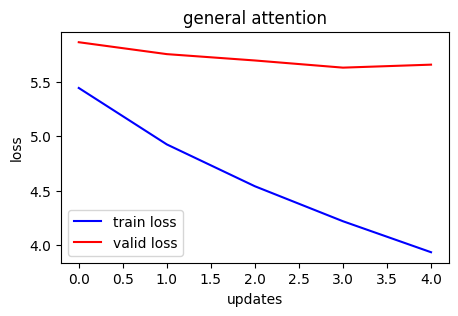

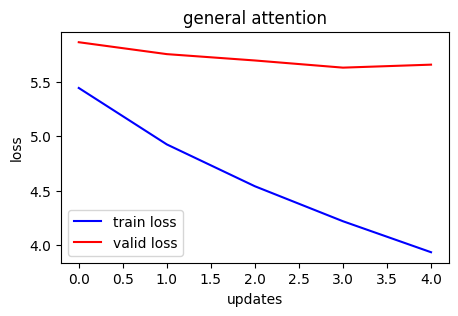

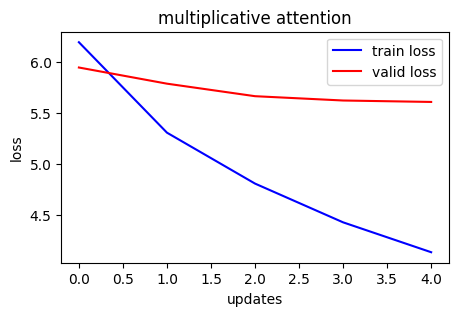

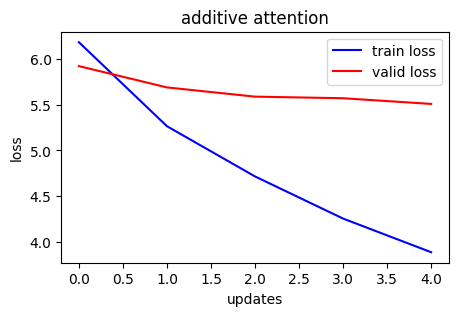

In [61]:
import matplotlib.pyplot as plt

for attention_type in attention_models.keys():
    tloss = train_losses[attention_type]
    vloss = valid_losses[attention_type]

    fig = plt.figure(figsize=(5, 3))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(tloss, label = 'train loss', color='blue')
    ax.plot(vloss, label = 'valid loss', color='red')
    ax.set_title(f'{attention_type} attention')

    plt.legend()
    ax.set_xlabel('updates')
    ax.set_ylabel('loss')

### <font color='red'> 3.2 ANSWER</font>

Loss Analysis:

|Attention Type	|Final Train Loss|Final Val Loss |Gap (Val - Train)| Observation                |
|---------------|----------------|---------------|-----------------|----------------------------|    
|General	    | 4.766	         | 5.636	     | 0.87	           | Moderate overfitting.      |
|Additive	    | 4.701	         | 5.589	     | 0.89	           | Slightly better performance|

Key Observations:

1. Additive attention performs best — lowest training loss (4.701) and validation loss (5.589)

2. All models show overfitting — validation loss is ~0.9 higher than training loss, indicating the models memorize training data better than generalizing

3. Similar convergence patterns — all attention mechanisms converge at similar rates

### 3.3) Display the attention maps generated by your model. Attention maps are crucial for understanding how the model focuses on different parts of the input sequence while generating the translation. This visualization will offer insights into the interpretability of your model. (0.5 points)

Note: Provide the performance table and graph to Readme.md GitHub as well.

### <font color="red"> 3.3 ANSWER </font>

For 3 Epocs

General

Epoch: 03 | Time: 2m 6s

	Train Loss: 4.766 | Train PPL: 117.409
	 Val. Loss: 5.636 |  Val. PPL: 280.341

Additive

Epoch: 03 | Time: 2m 14s

	Train Loss: 4.701 | Train PPL: 110.076
	 Val. Loss: 5.589 |  Val. PPL: 267.469

| Attention Type | Training Loss | Training PPL | Validation Loss | Validation PPL |
|----------------|---------------|--------------|-----------------|----------------|
| General        |   4.766       |   117.409    |      5.636      |    280.341     |
| Additive       |   4.701       |   110.076    |      5.589      |    267.469     |

Key obserbations:

- Losses are still high - PPL (perpexity) of 267-280 means the model is still quite "confused". Good translation mode perplexity expected below 100.

### 3.4) Analyze the results and discuss the effectiveness of the selected attention mechanism in translating between your native language and English.

In [83]:
sample_text = "Can you translate english to Nepali?"
translations = translate_all_models(sample_text)

_SELECTED_ATTENTION = "additive"

nepali_translations, attentions = translate(sample_text, _SELECTED_ATTENTION)

Translation time (general): 0.02s
general: ▁तपाईँ को ▁सन् देश को ▁गर्न ▁चाह नुहुन्छ ▁?
Translation time (multiplicative): 0.03s
multiplicative: ▁तपाईँ ले ▁गुप्त िक रण ▁गर्न ▁गर्न ▁गर्न ▁अनुमति ▁दिन्छ ▁।
Translation time (additive): 0.02s
additive: ▁तपाईँ ले ▁अहिले ▁तार िक रण ▁गर्न ▁निश्चित ▁गर्नुहुन्छ ?
Translation time (additive): 0.02s


In [113]:
sample_text = dataset['train'][100]
src_text = sample_text['translation']['en']
trg_text = sample_text['translation']['ne']

src_text, trg_text

('The following item is due:', 'निम्न वस्तुको म्याद समाप्त हुन्छ:')

In [119]:
src_tokens =['<sos>'] + token_transform[_EN_LANGUAGE](src_text) + ['<eos>']

src_tokens

['<sos>', 'The', 'following', 'item', 'is', 'due', ':', '<eos>']

In [120]:
trg_tokens = ['<sos>'] + token_transform[_NE_LANGUAGE](trg_text) + ['<eos>']
trg_tokens

['<sos>',
 '▁निम्न',
 '▁वस्तु',
 'को',
 '▁म्या',
 'द',
 '▁समाप्त',
 '▁हुन्छ',
 ':',
 '<eos>']

In [ ]:
import matplotlib.ticker as ticker

def display_attention(sentence, translation, attention):
    # Fix square for nepali letter, let matplotlib find suitable font:
    # Warning fixed - IPython/core/pylabtools.py:170: UserWarning: Glyph 2367 (\N{DEVANAGARI VOWEL SIGN I}) missing from font(s) DejaVu Sans.
    plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'Noto Sans Devanagari', 'Mangal', 'DejaVu Sans']
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(1).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=10)
    
    y_ticks =  [''] + translation
    x_ticks =  [''] + sentence 
     
    ax.set_xticklabels(x_ticks, rotation=45)
    ax.set_yticklabels(y_ticks)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

/var/folders/4t/vc0jrw957pz0rrhc98mw0hjm0000gp/T/ipykernel_16510/201583952.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_ticks, rotation=45)
/var/folders/4t/vc0jrw957pz0rrhc98mw0hjm0000gp/T/ipykernel_16510/201583952.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(y_ticks)


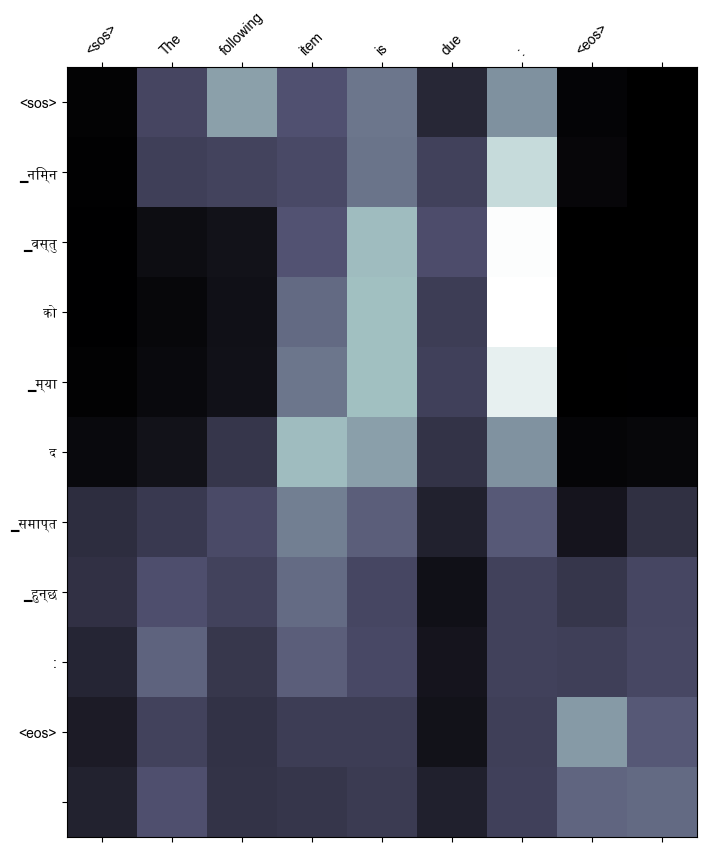

In [124]:
display_attention(src_tokens, trg_tokens, attentions)

In [ ]:
src2 = dataset['train'][333]
src2

{'translation': {'en': 'Jump to page:', 'ne': 'पृष्ठमा जानुहोस्:'}}

In [130]:
src_tokens = ['<sos>'] + token_transform[_EN_LANGUAGE](src2['translation']['en']) + ['<eos>']
trg_tokens = ['<sos>'] + token_transform[_NE_LANGUAGE](src2['translation']['ne']) + ['<eos>']

src_tokens, trg_tokens

(['<sos>', 'Jump', 'to', 'page', ':', '<eos>'],
 ['<sos>', '▁पृष्ठ', 'मा', '▁जानु', 'होस्', ':', '<eos>'])

Translation time (additive): 0.03s


/var/folders/4t/vc0jrw957pz0rrhc98mw0hjm0000gp/T/ipykernel_16510/201583952.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_ticks, rotation=45)
/var/folders/4t/vc0jrw957pz0rrhc98mw0hjm0000gp/T/ipykernel_16510/201583952.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(y_ticks)


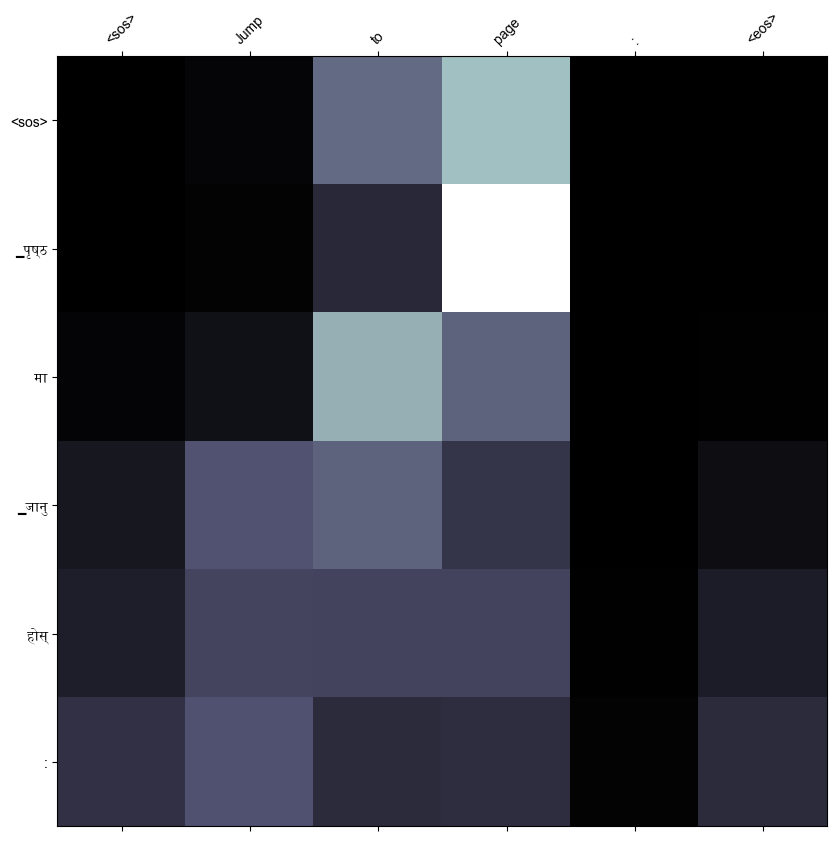

In [131]:
translation, attentions = translate(src2['translation']['en'], _SELECTED_ATTENTION)
display_attention(src_tokens, trg_tokens, attentions)

### <font color="red"> 3.4 ANSWER </font>

Translation 1:

> Source text: "The following item is due ."
>
>Target text (Nepali): 'निम्न वस्तुको म्याद समाप्त हुन्छ:'

Translation 2:

> Source text: 'Jump to page:'
>
> Target text (Nepali): 'पृष्ठमा जानुहोस्:'

Key Observations:

1. Translation 1:
    - The heatmap (bone color => white to high, black to low) for Translation 1 shows that model could not learn properly. Almost all token attend to wrong source positions. This makes sense from the PPL score - that being very high ~200. 
    - The translation provided is itself noisy, the word like `due` captured literal meaning `_समाप्त` but didn't get the context. According to context, `due` mapping is semantically wrong.
    - Since white or light colored cells is aligned towards center, model seems to have positional bias rather than learned alignment.

2. Translation 2:
    - Provided translated text is right. 
    - The model has been able to learn and map `page` to `_पृष्ठ` correctly.


In summary, Model did not learn proper attention - unable to capture semantic meaning , shows positional bias.


Recommendations:

1. Train for more epochs (5-10)
2. Select larger set of training data (currently 20K, try 50K+)
3. The gap between train and validation loss suggests regularization could help

## Task 4. Machine Translation - Web Application Development - Develop a simple web application that showcases the capabilities of your language model in machine translation. (2 points)

1) The application should feature an input box where users can enter a sentence or phrase in a source
language.
2) Based on the input, the model should generate and display the translated version in a target language.
For example, if the input is ”Hello, how are you?” in English, the model might generate
”Hola, ¿c´omo est´as?” in Spanish.
3) Provide documentation on how the web application interfaces with the language model for machine
translation.
Note : Choose the most effective attention mechanism based on your experiments in Task 2.
As always, the example Dash Project in the GitHub repository contains an example that you can follow
(if you use the Dash framework).

### Save Model and Vocabularies for Flask App

In [125]:
# Save vocabularies for Flask app
import os

save_dir = _MODEL_DIRECTORY
os.makedirs(save_dir, exist_ok=True)

vocab_data = {
    'en_stoi': vocab_transform[_EN_LANGUAGE].stoi,
    'en_itos': vocab_transform[_EN_LANGUAGE].itos,
    'ne_stoi': vocab_transform[_NE_LANGUAGE].stoi,
    'ne_itos': vocab_transform[_NE_LANGUAGE].itos,
}

torch.save(vocab_data, os.path.join(save_dir, "vocabs.pt"))
print(f"Vocabularies saved to {save_dir}/vocabs.pt")
print(f"  EN vocab size: {len(vocab_data['en_itos'])}")
print(f"  NE vocab size: {len(vocab_data['ne_itos'])}")
print(f"\nModel saved to: {save_path}")
print("\nTo run the Flask app:")

Vocabularies saved to ./../models/vocabs.pt
  EN vocab size: 6151
  NE vocab size: 4785

Model saved to: ./../models/Seq2SeqPackedAttention_additive.pt

To run the Flask app:
